# 附录 C： 高斯过程

 <style>p{text-indent:2em;2}</style>

【原文】Jie Wang (2020). An Intuitive Tutorial to Gaussian Processes Regression. https://arxiv.org/abs/2009.10862

【摘要】本教程旨在提供对高斯过程回归（Gaussian processes regression,高斯过程回归）的直观理解。高斯过程回归模型因其表达方式的灵活性和内涵的不确定性预测能力而广泛用于机器学习应用中。本文首先解释了构建高斯过程的基本概念，包括多元正态分布、核、非参数模型、联合和条件概率等。然后，简明描述了高斯过程回归以及标准高斯过程回归算法的实现。除了标准高斯过程回归，本文还审查了目前最先进的高斯过程算法软件包。

---

<style>p{text-indent:2em;2}</style>

## 1 引言

高斯过程模型是一种概率监督机器学习框架，已广泛用于回归和分类任务。高斯过程回归（高斯过程回归）模型可以结合先验知识（核）进行预测，并提供预测的不确定性度量 [1]。高斯过程模型是由计算机科学和统计学界开发的一种监督学习方法。具有工程背景的研究人员经常发现很难清楚地了解它。要理解高斯过程回归，即使只有基础知识也需要了解多元正态分布、核、非参数模型以及联合和条件概率。

在本教程中，我们将提供高斯过程回归的简洁易懂的解释。我们首先回顾了高斯过程回归模型所基于的数学概念，以确保读者有足够的基础知识。为了提供对高斯过程回归的直观理解，图表被积极使用。为生成绘图而开发的代码在 https://github.com/jwangjie/Gaussian-Processes-Regression-Tutorial 处提供。

在开始之前，首先要了解为什么要用高斯过程做回归。回归是一项常见的机器学习任务，可以描述为给定一些观测到的数据点（训练数据集），找到一个尽可能接近地表示数据集的函数，然后使用该函数对新数据点进行预测。可以使用多种函数形式进行回归，并且通常有不止一种可能的函数可以拟合观测到的数据。除了通过函数获得预测结果之外，我们还想知道这些预测的确定性程度。量化不确定性对于实现高效的学习过程非常有价值，应该更多地探索低确定性的领域。而高斯过程不仅可用于对新数据点进行预测，并可以告诉我们这些预测的不确定性程度。

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/gpr_animation_wide.gif?raw=1" width="1000"/> 

高斯过程的动画示意图 [10]

## 2 数学基础

本节回顾理解高斯过程回归所需的基本概念。从高斯（正态）分布开始，然后解释多元高斯分布、核、非参数模型的概念，尤其是多元高斯分布的边缘概率和条件概率公式。在回归任务中，给定一些观测到的数据点，我们的目的是拟合一个函数来表示这些数据点，然后使用该函数对新数据点进行预测。例如：对于 `图 1(a)` 所示的一组观测数据点，理论上存在无数个能够拟合这些数据点的函数。`图 1（b）` 示例性地展示了其中五个可能的函数。在高斯过程回归中，高斯过程正是通过定义这无限个函数的分布，来处理回归问题的 [12]。

<div id="image-table">
    <table>
	    <tr>
    	    <td style="padding:10px">
        	    <img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/regression1.png?raw=1" width="400"/> 
      	    </td>
            <td style="padding:10px">
            	<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/regression2.png?raw=1" width="550"/>
            </td>
        </tr>
    </table>
</div> 

图 1 回归任务示例：(a) 观测数据点，(b) 拟合观测数据点的五个函数样本。[2]

### 2.1 高斯分布

当某个随机变量 $X$ 的概率密度函数为下述公式时，称其服从均值为 $μ$ 、方差为 $σ^2$ 的高斯分布[13]：

$$
P_X(x) = \frac{1}{\sqrt{2 \pi} \sigma} exp{\left(-\frac{{\left(x - \mu \right)}^{2}}{2 \sigma^{2}}\right)}
$$

其中， $X$ 表示随机变量， $x$ 表示变量实值。$X$ 的高斯（或正态）分布通常表示为 $ P(x) ~ \sim\mathcal{N}(\mu, \sigma^2)$ 。

下图为一维（单变量）高斯密度函数。我们从该分布中随机采样了 `1000` 个样本点，并将其绘制在 $x$ 轴上。

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.format'] = 'pdf'

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


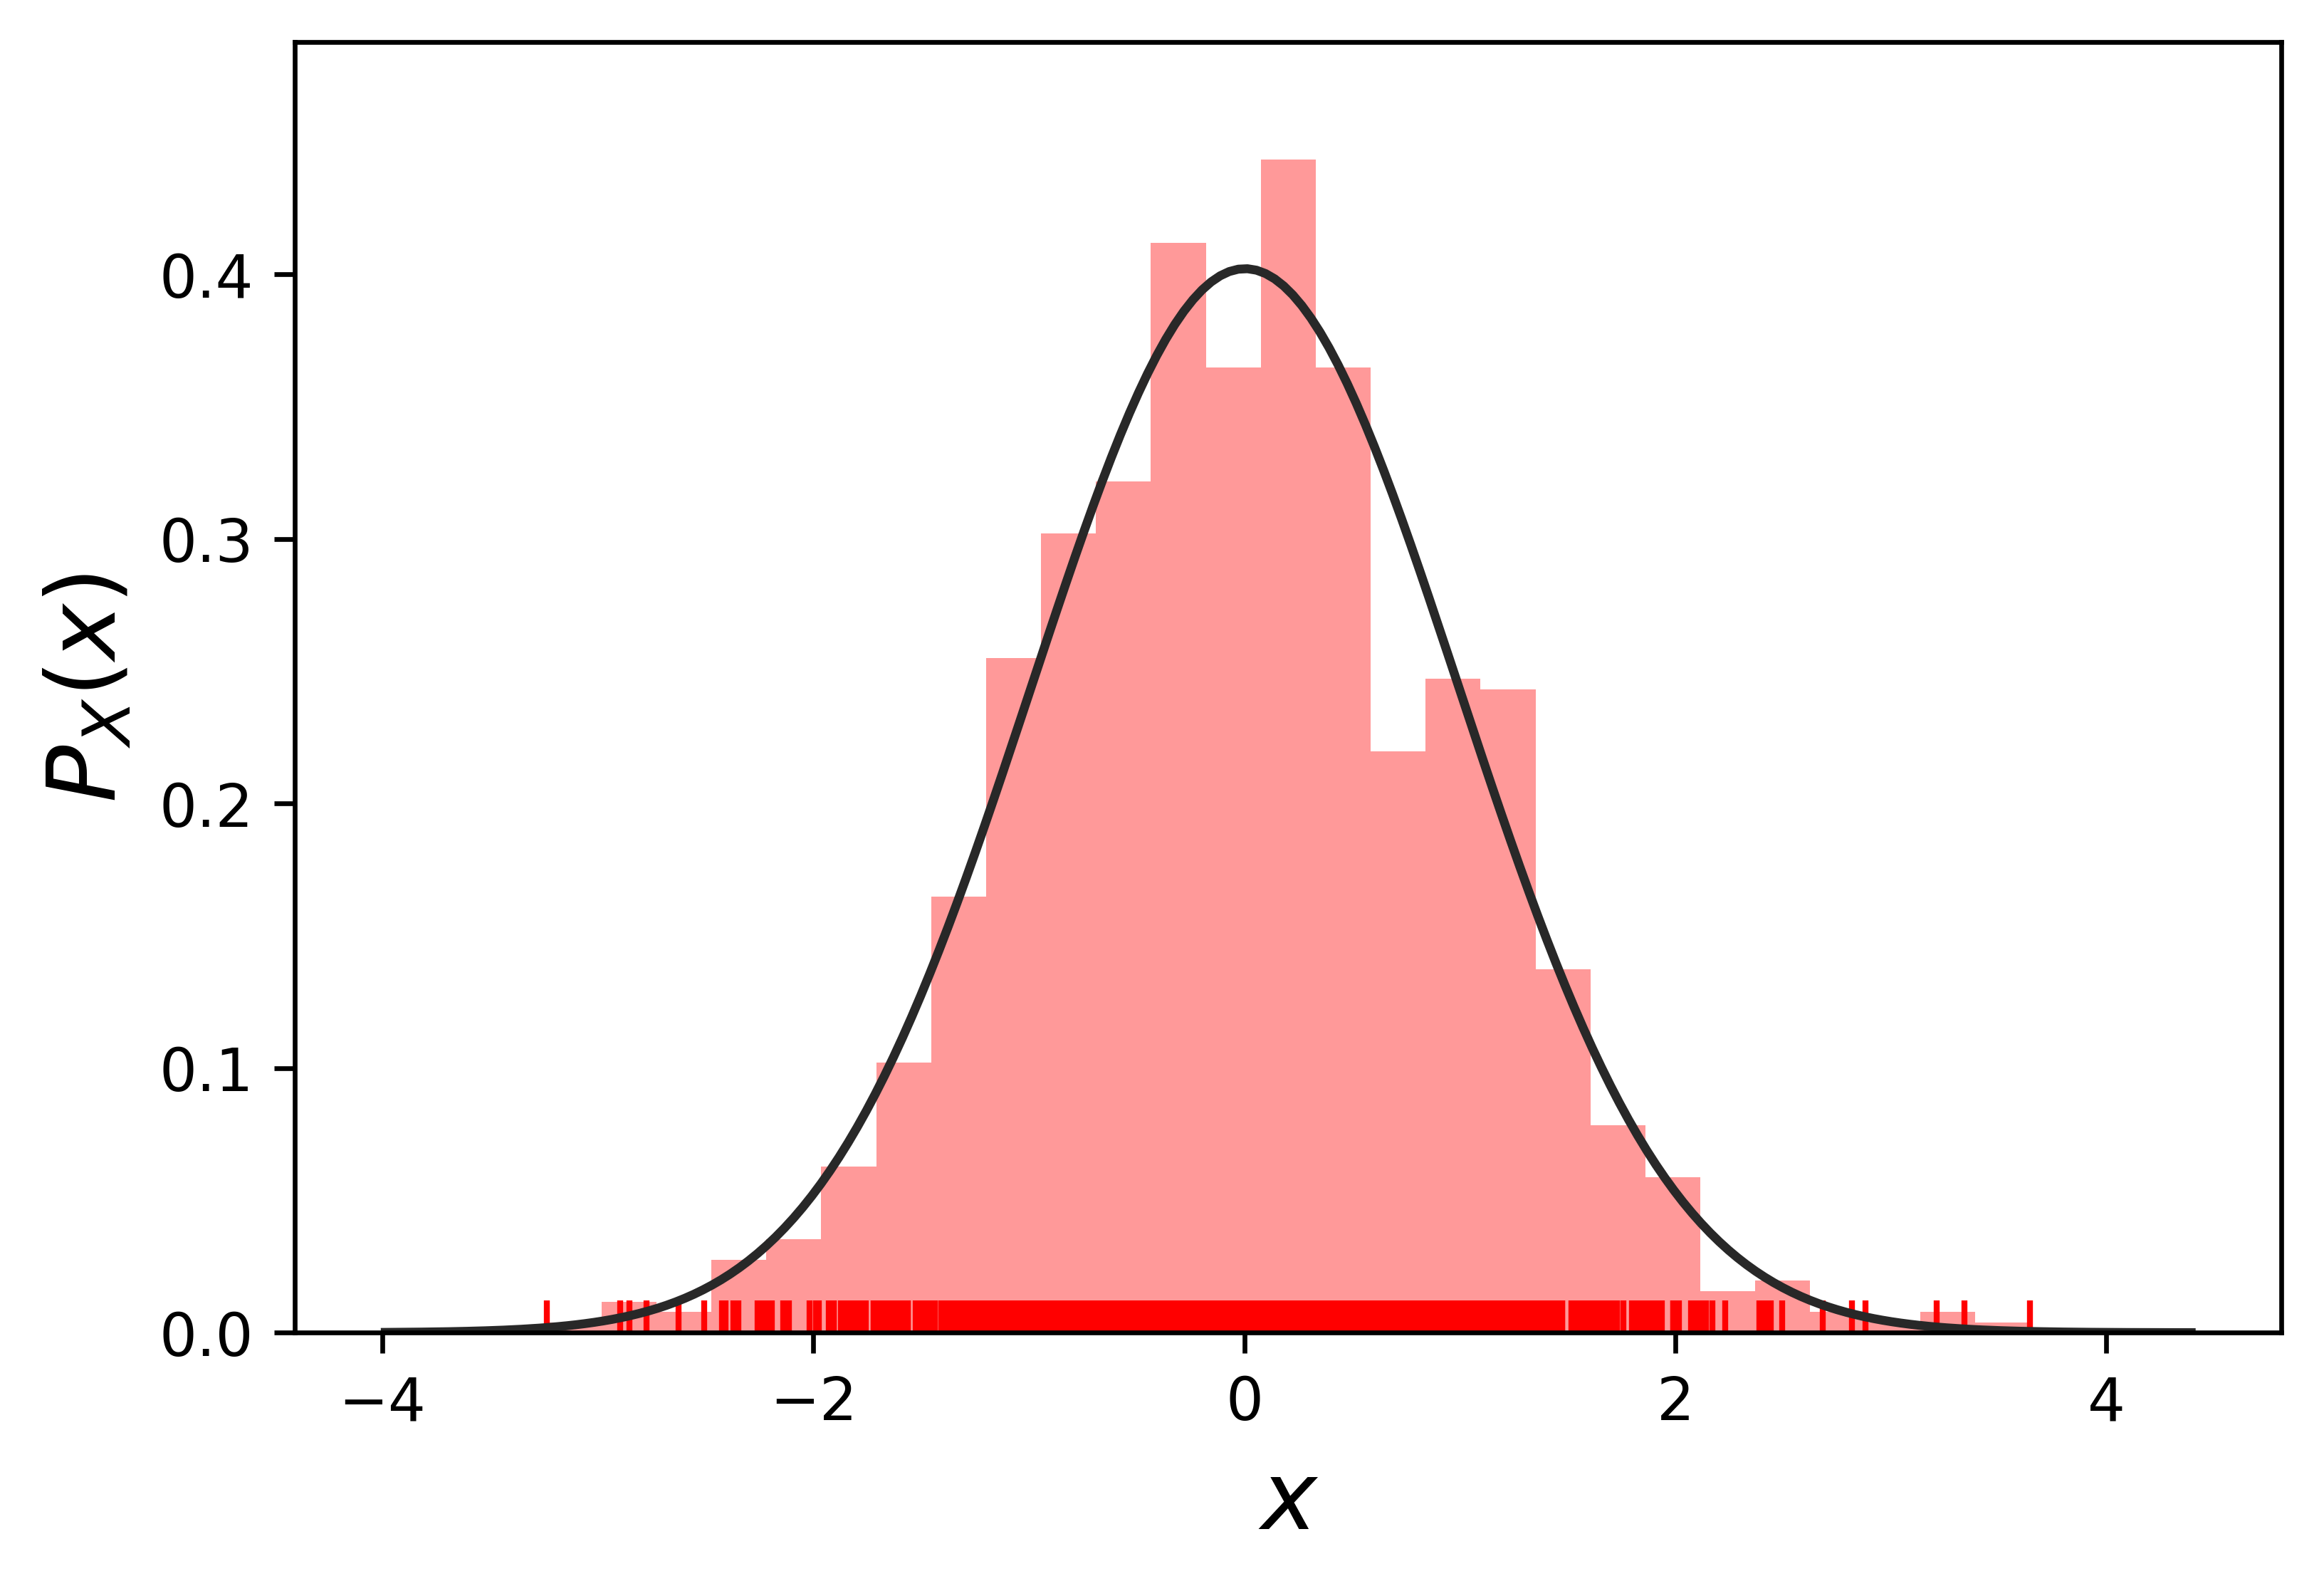

In [3]:
from scipy.stats import norm

# Plot 1-D gaussian
n = 1         # n number of independent 1-D gaussian 
m= 1000       # m points in 1-D gaussian 
f_random = np.random.normal(size=(n, m)) 
# more information about 'size': https://www.sharpsightlabs.com/blog/numpy-random-normal/ 
#print(f_random.shape)

for i in range(n):
    #sns.distplot(f_random[i], hist=True, rug=True, vertical=True, color="orange")
    sns.distplot(f_random[i], hist=True, rug=True, fit=norm, kde=False, color="r", vertical=False)

#plt.title('1000 random samples by a 1-D Gaussian')

plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$P_X(x)$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
plt.savefig('1d_random')

图 2 1000 个高斯分布的数据点被绘制在 x 轴上（红色垂直条），这些数据点的概率密度函数（PDF）被绘制为二维钟形曲线

我们生成的数据点遵循正态分布。另一方面，我们可以对数据点进行建模，假设这些点是高斯的，建模为一个函数，并利用它做回归。如上所示，对生成的点进行了核密度和直方图的估计。由于有大量的`(m=1000)` 观测点来得到这个看起来像高斯的PDF，核密度估计看起来是一个正态分布。在贝叶斯概率回归方法中，即使没有那么多的观测数据，如果假设高斯先验，也可以将数据建模为一个遵循正态分布的函数。

这些随机生成的数据点可以表示为向量 $x_1= [x^1_1,x^2_1, . . . ,x^n_1]$ 的形式。此时做些坐标空间上转换，将向量 $x_1$ 绘制在 $Y=0$ 的新 $Y$ 轴上，即将点 $[x^1_1,x^2_1, . . . ,x^n_1]$ 投影到了 `图 3` 所示的另一个空间。在该空间中，我们只在特定的 $Y$ 值上, 按照垂直方向绘制向量 $x_1$ 中的点。例如，可以在 $Y=1$ 处绘制另一个独立的高斯向量 $x_2= [x^1_2,x^2_2, . . . ,x^n_2]$ 。 注意，此时心里应当清楚， $x_1$ 和 $x_2$ 均为图 2 所示的一维高斯分布。

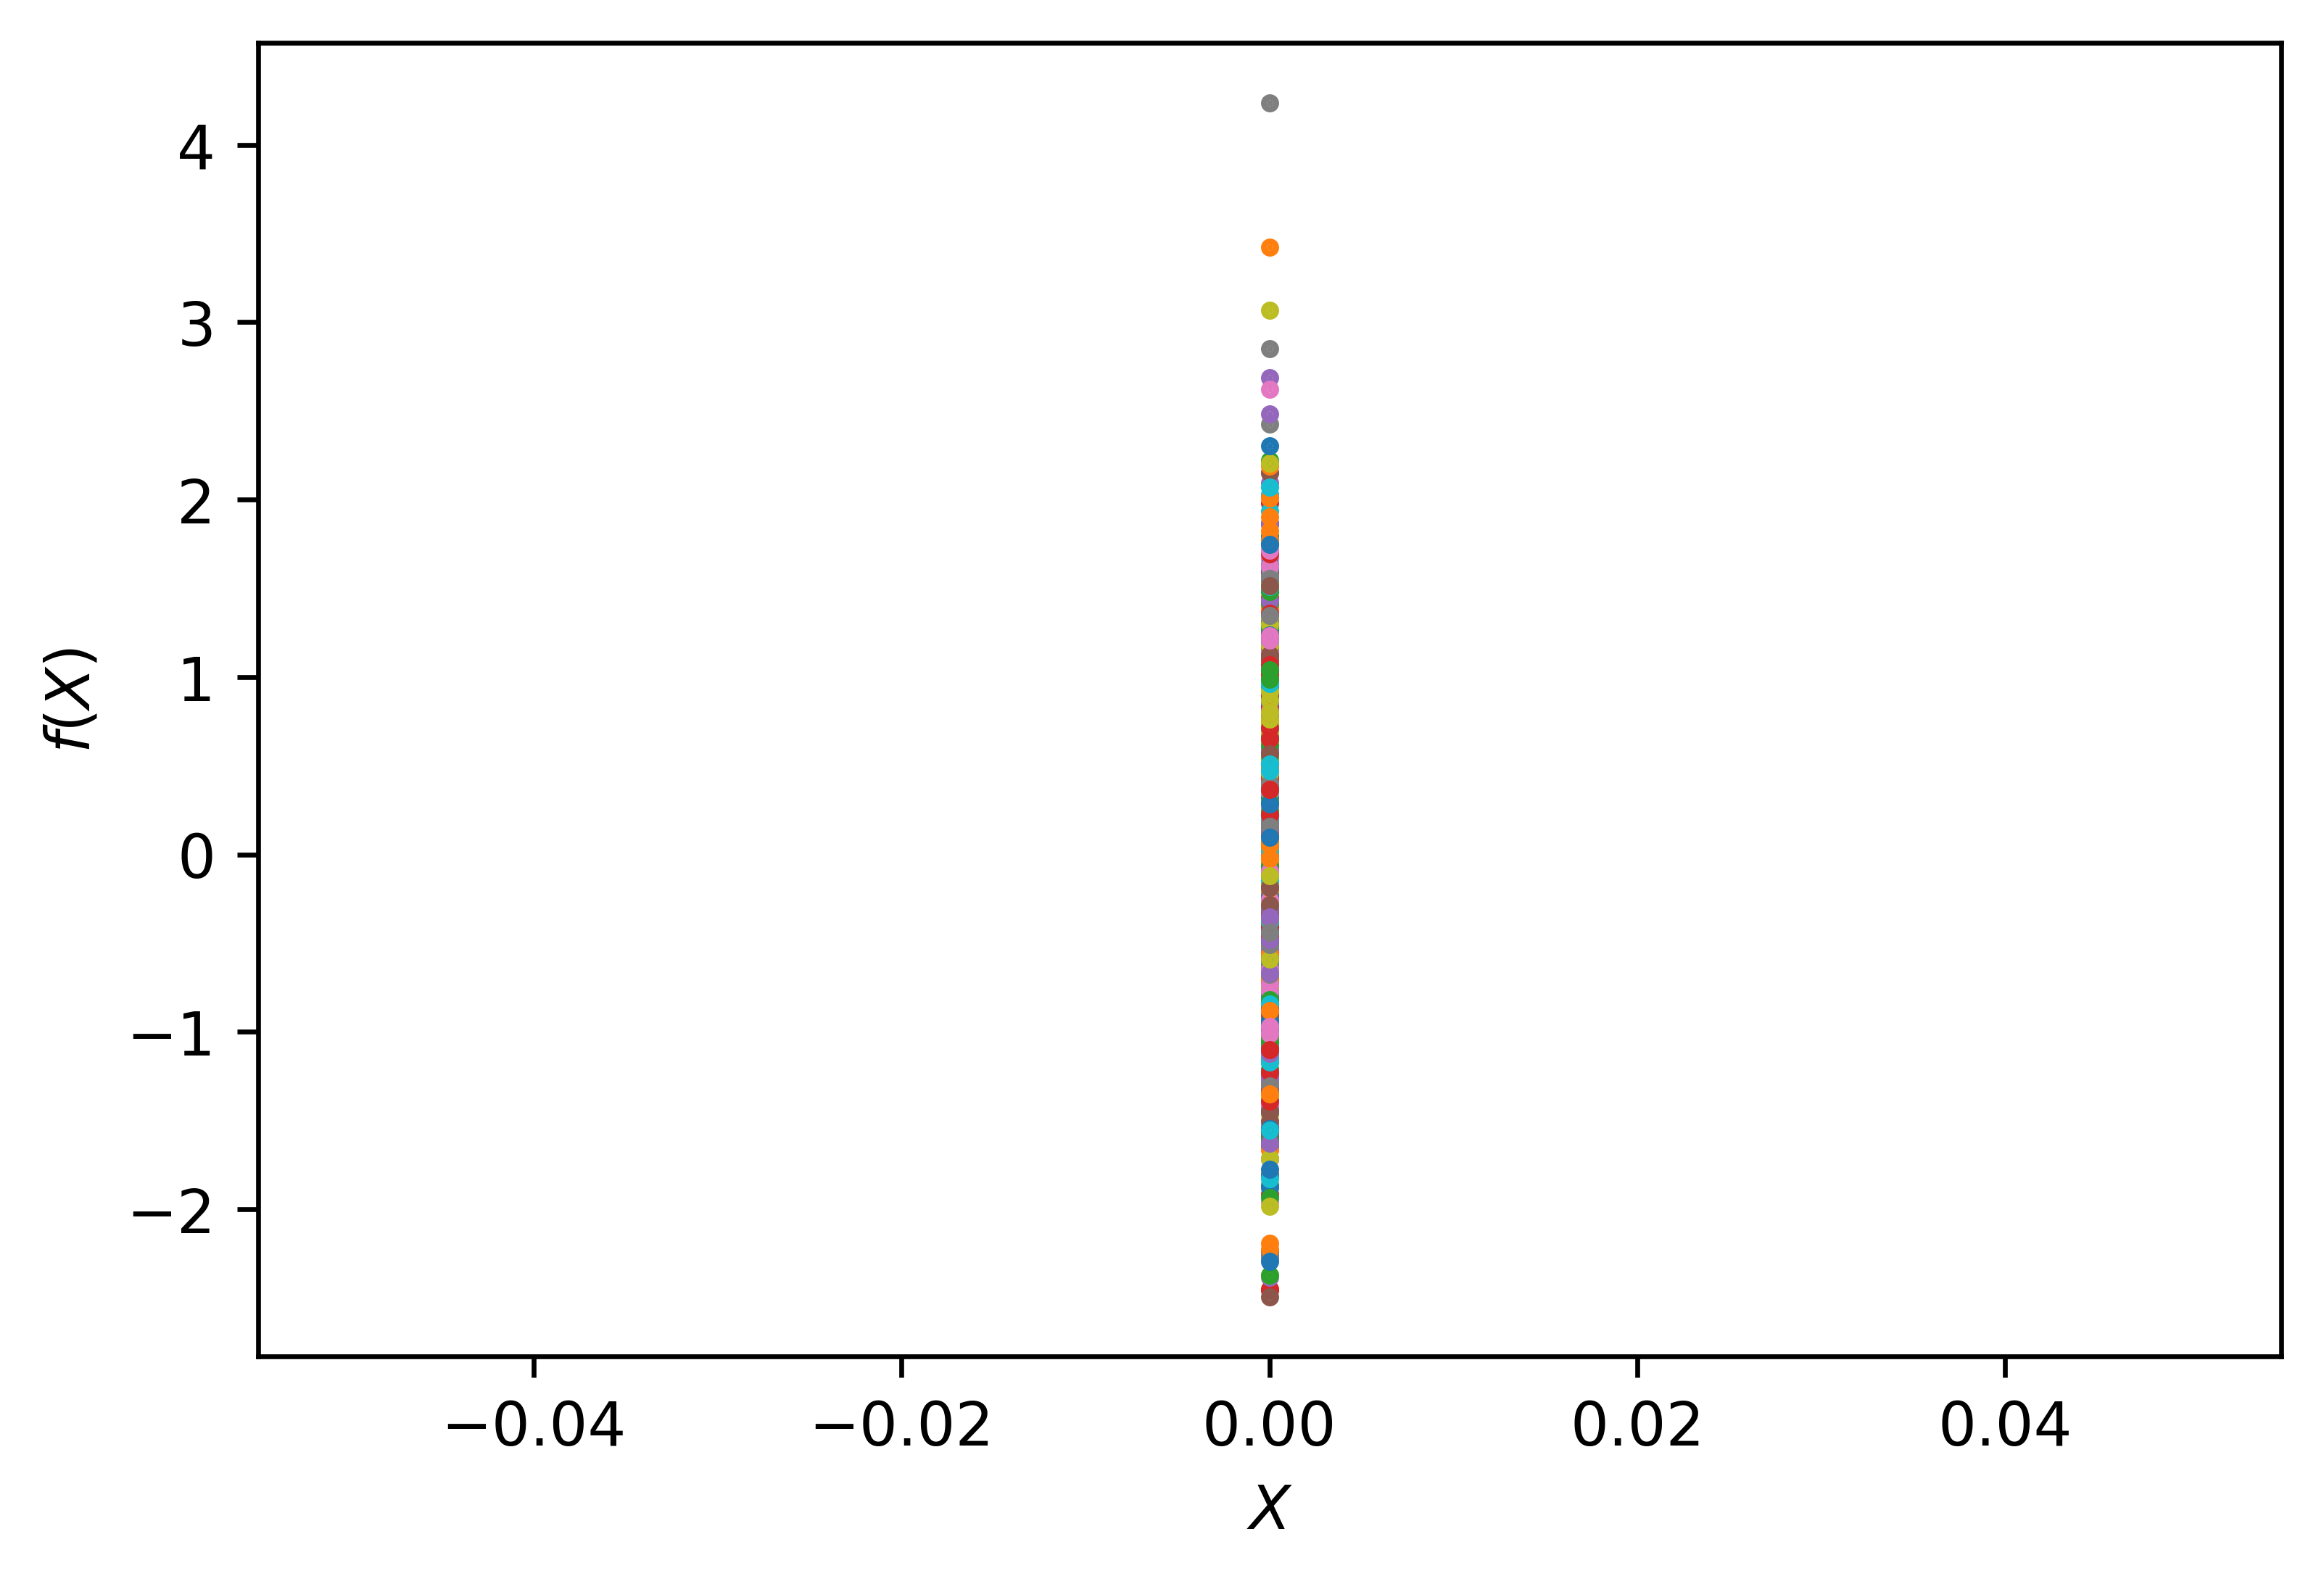

In [4]:
n = 1         # n number of independent 1-D gaussian 
m = 1000       # m points in 1-D gaussian  
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, 'o', linewidth=1, markersize=1, markeredgewidth=2)
plt.xlabel('$X$')
plt.ylabel('$f(X)$')
plt.show()

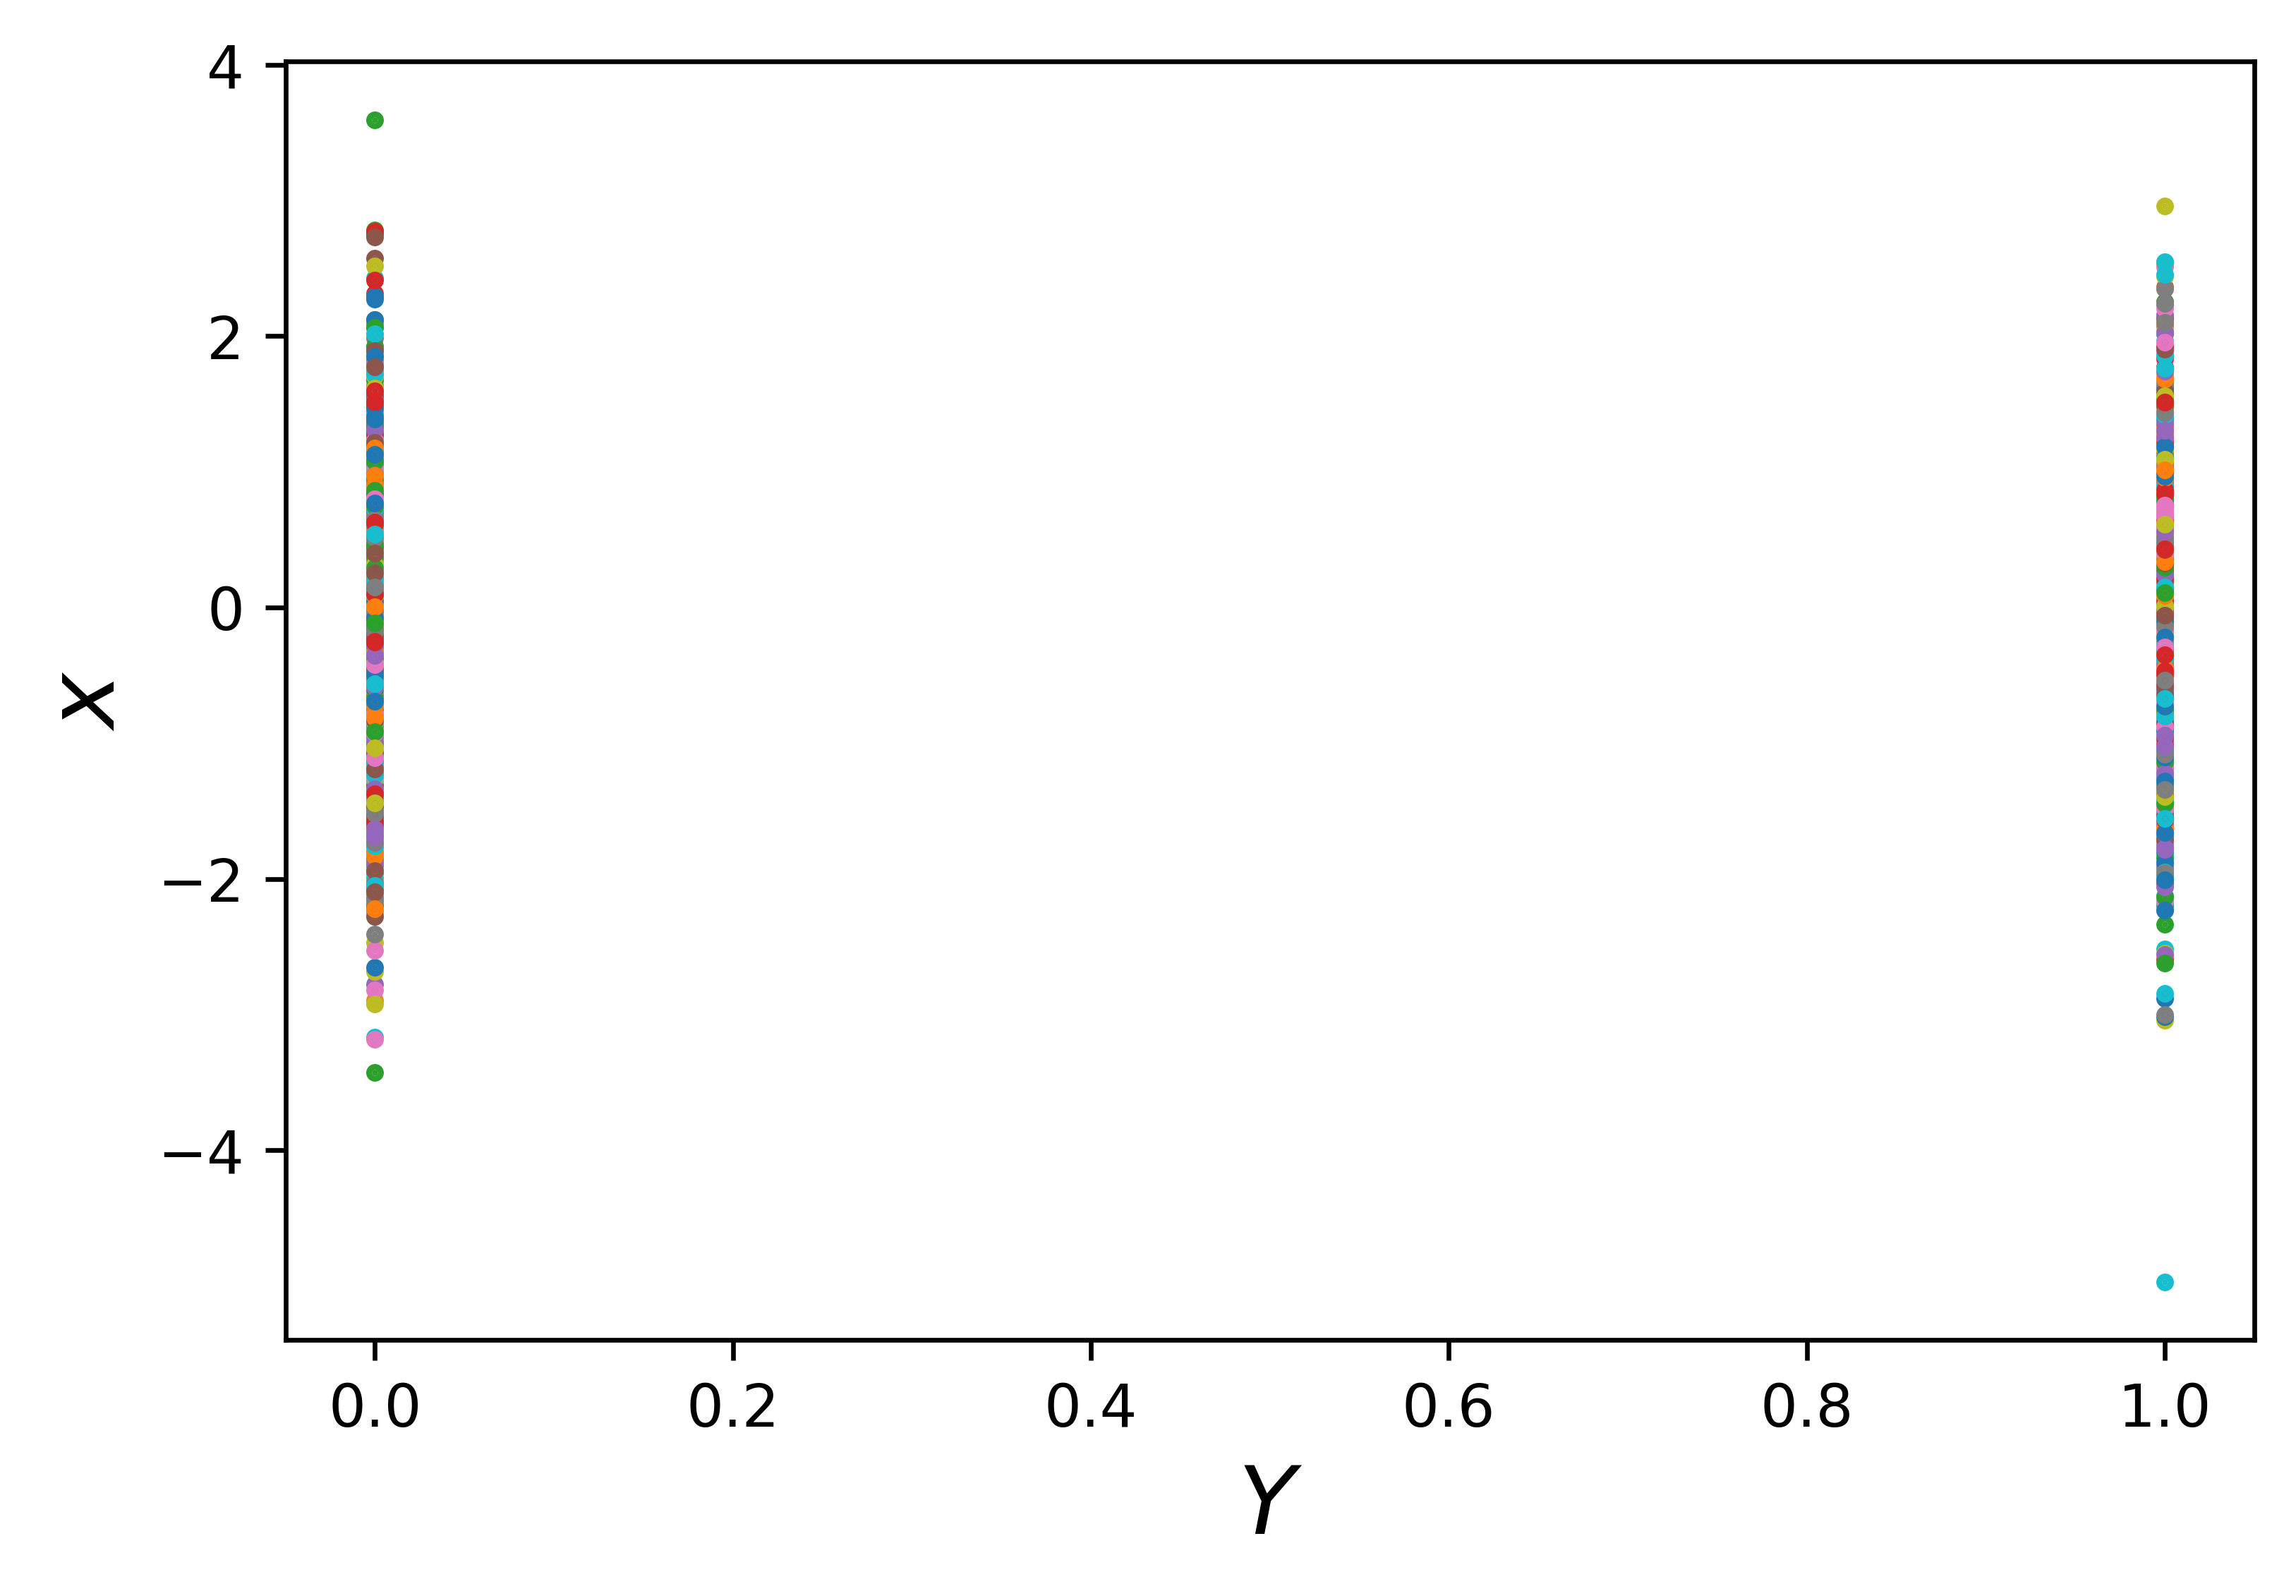

In [5]:
n = 2          
m = 1000
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, 'o', linewidth=1, markersize=1, markeredgewidth=2)

plt.xlabel(r'$Y$', fontsize = 16)
plt.ylabel(r'$x$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
plt.savefig('2gaussian')

图 3：在 $Y-X$ 坐标空间中垂直绘制了两个独立的一维高斯向量点集合。

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2gaussian.png?raw=1" width="500"/>

接下来，我们分别在向量 $x_1$ 和 $x_2$ 中随机选择 10 个点，并按线顺序连接这 10 个点，如 `图 4（a）` 所示。这些连接线看起来像跨越 $[0, 1]$ 区间的线性函数。如果新数据点在（或足够接近）这些直线上，则可以使用这些函数对回归任务进行预测。然而，在大多数情况下，“新数据点总是在连接的线上” 这个假设并不成立。

Text(0, 0.5, '$x$')

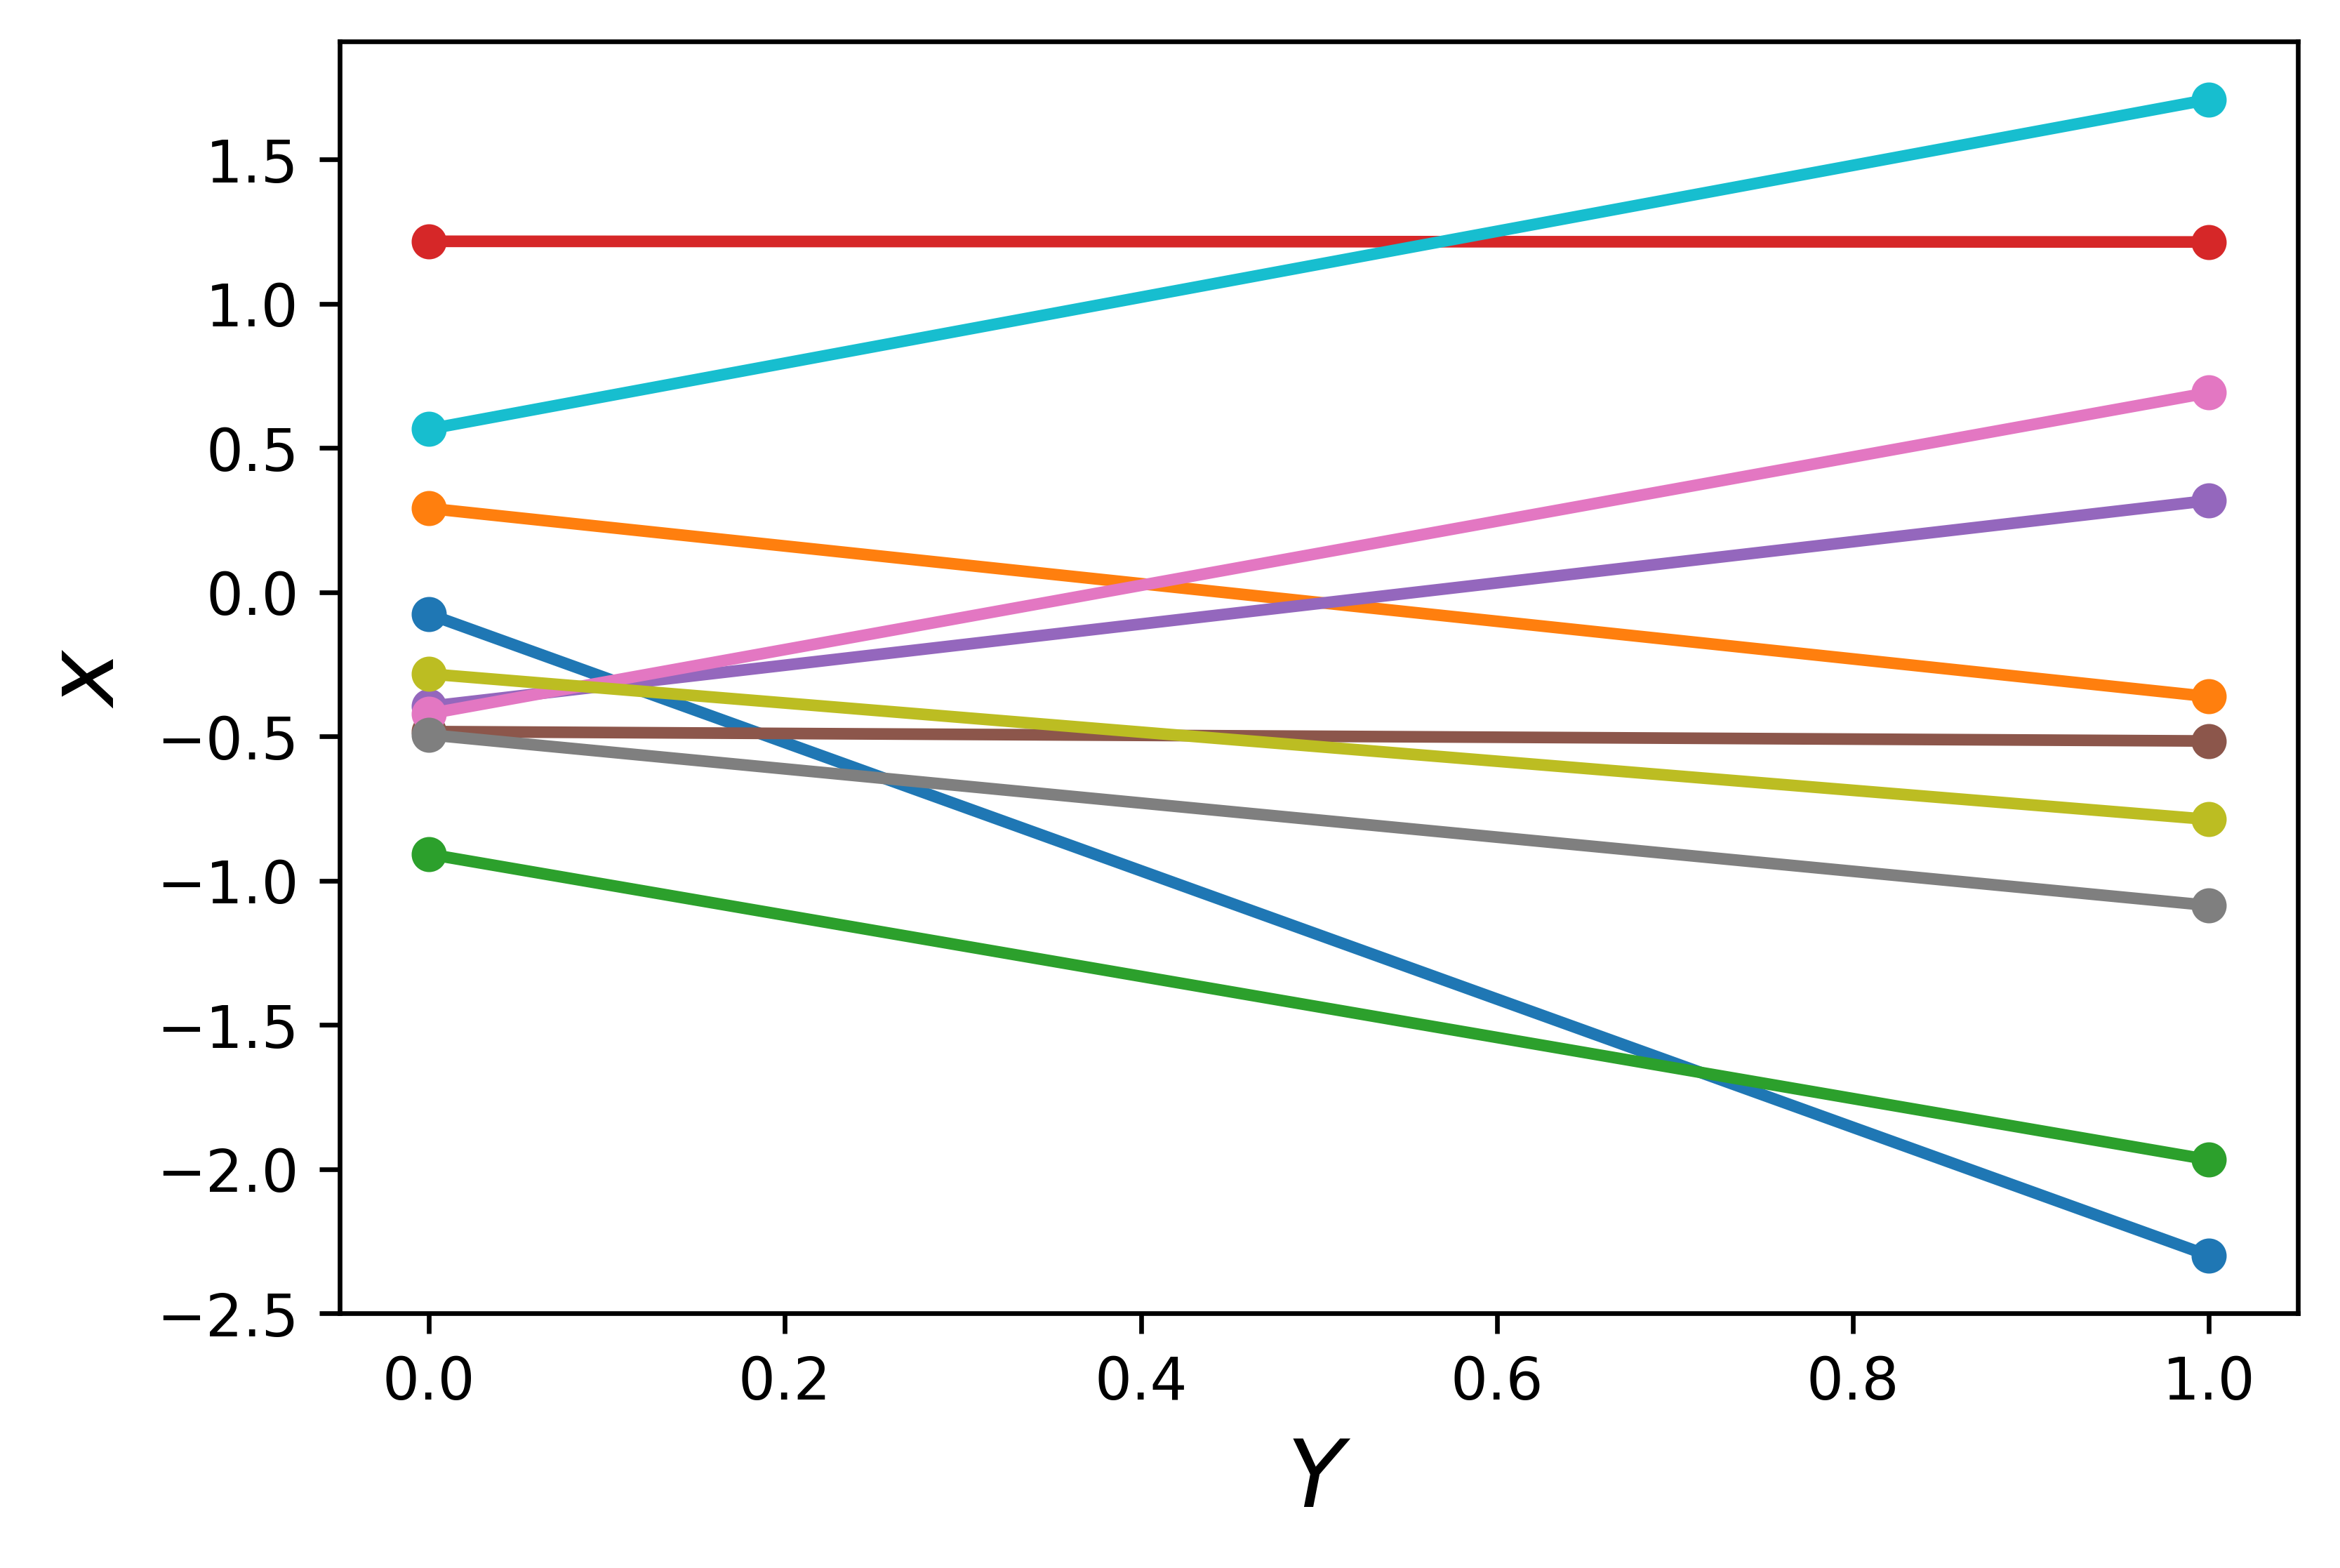

In [6]:
n = 2          
m = 10
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, '-o', linewidth=2, markersize=4, markeredgewidth=2)
plt.xlabel(r'$Y$', fontsize = 16)
plt.ylabel(r'$x$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
# plt.savefig('random_x1_x2')

图 4a 在两个向量 $x_1$ 和 $x_2$ 中随机选取 10 个点，并连接成线，形成 10 个可能的函数。

重新考虑回归问题，对于每对点，上述直线看起来像是某个函数。另一方面，即使每条线上只有两个点，该图也看起来很像正在使用 10 个线性函数对 $[0, 1]$ 区间进行采样。从采样角度来看，$[0, 1]$ 区间是进行回归的兴趣区域。如果按轴顺序生成更多独立的高斯向量和连接点，则这种采样看起来会更加清晰。例如，在 $[0,1]$ 区间内，随机生成 20 个向量 $x_1$,$x_2$,...,$x_{20}$，并将每个向量中的 10 个随机样本点按顺序连接为折线，则可以得到`图 4（b）` 所示的 10 条新的折线，这些折线看起来更像 $[0, 1]$ 区间上的函数了。但此时我们仍然无法使用这些线来做预测，因为它们太杂乱了。原则上，我们希望这些线代表的函数应当更平滑一些，这也意味着彼此接近的输入点应该具有相似的输出值。

Text(0, 0.5, '$x$')

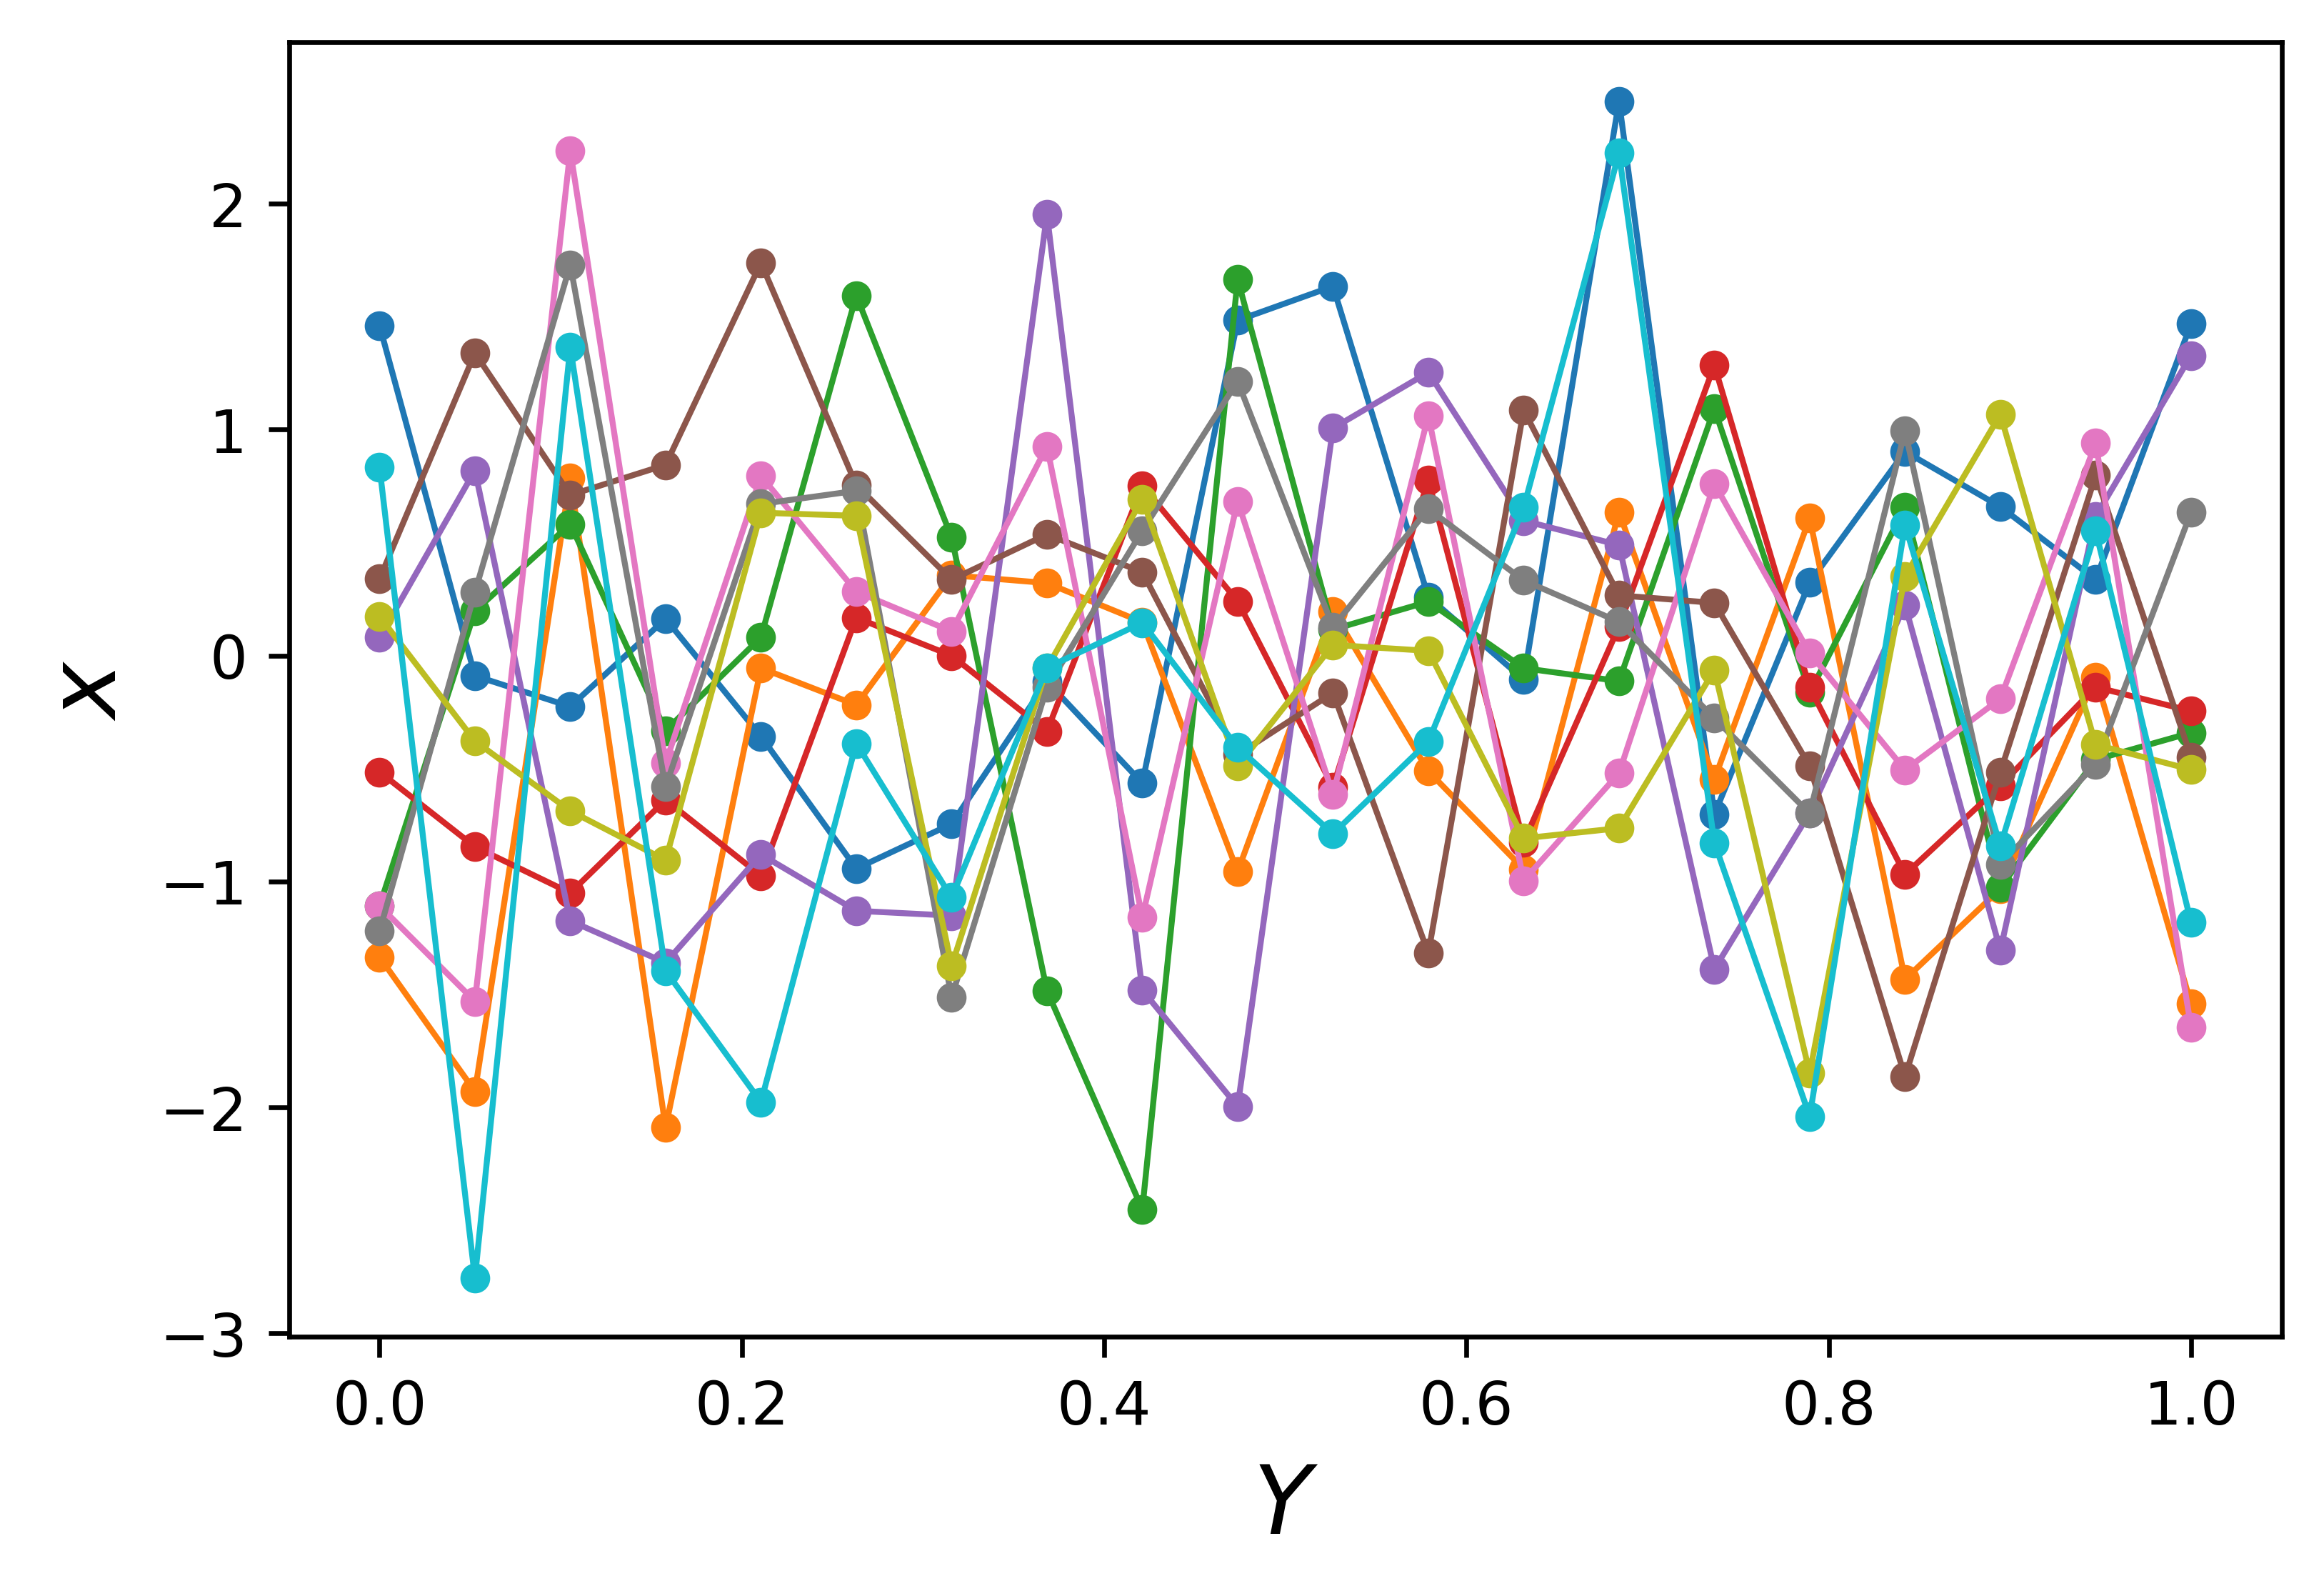

In [7]:
n = 20          
m = 10
f_random = np.random.normal(size=(n, m))

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
plt.plot(Xshow, f_random, '-o', linewidth=1, markersize=3, markeredgewidth=2)

plt.xlabel(r'$Y$', fontsize = 16)
plt.ylabel(r'$x$', fontsize = 16)

# plt.show()
# plt.savefig('1d_random.png', bbox_inches='tight', dpi=600)
# plt.savefig('random_x1_x20')

图 4b 在 20 个向量 $x_1$, $x_2$,...,$x_{20}$ 中随机选取 10 个样本点，并连接成线，形成 10 个可能的函数

图 4 两例说明，通过连接独立的高斯向量点生成的 “函数”， 对于回归任务来说不够平滑。造成这种不平滑的主要原因是 20 个高斯向量（本质上每个向量代表了在 Y 处的一个随机变量抽取的样本集合）所抽取的样本点之间，彼此相互独立。因此，如果要保持某种程度的平滑，就需要 20 个相邻的样本点之间存在一定程度的相关性（距离越接近，则样本的值越接近）。从数学上，20 个随机变量的高斯分布，可以等价地视为一个 20 维的多元高斯分布，而多元高斯分布具备很多成熟而有价值的数学定理，能够用于预测概率的求解。

### 2.2 多元高斯分布（多元高斯分布）

一个系统通常由相互关联的多个特征变量 $(x_1，x_2，...，x_D)$ 描述。如果想将所有 $D$ 个变量统一建模为一个高斯模型，就要使用多元高斯分布[13]。具有 $D$ 维的多元高斯分布具有如下概率密度函数：

$$
p(\mathbf{x})=\frac{1}{(2 \pi)^{D / 2}|\Sigma|^{1 / 2}} \exp \left\{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{T} \Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})\right\}
$$

其中：$D$ 为维度数量，$X$ 为变量（向量形式），$\boldsymbol{\mu} \quad$ 为均值向量，$\Sigma$ 为协方差矩阵。

当 Dimension = 1 时，上式等价于一维高斯分布：

$$
p(x)=\frac{1}{\sqrt{2 \pi} \sigma} \exp \left\{-\frac{(x-\mu)^{2}}{2 \sigma^{2}}\right\}
$$

为简化问题，我们以二元高斯分布 （BVN） 分布为例来理解多元高斯分布理论。 二元高斯分布在三维（3-d）空间中，可描述为钟形曲面（图 5a ），其中高度表示概率密度 $P$ 。图 5b 是三维空间投影到 $x_1,x_2$ 平面上的结果，概率密度用等值线表示，其中椭圆的形状显示了两个维度 $x_1$ 和 $x_2$ 之间的相关性，即一个变量 $x_1$ 与另一个变量 $x_2$ 的相关程度。 $P(x_1,x_2)$ 是 $x_1$ 和 $x_2$ 的[联合概率分布](https://en.wikipedia.org/wiki/Joint_probability_distribution#Density_function_or_mass_function)。

对于二元高斯分布，均值向量 $\boldsymbol{\mu}$ 是二维向量 $\left[\begin{array}{l}\mu_{1} \\ \mu_{2}\end{array}\right]$，其中 $μ_1$ 和 $μ_2$ 分别是随机变量 $x_1$ 和 $x_2$ 的均值。协方差矩阵为 $\left[\begin{array}{ll}\sigma_{11} & \sigma_{12} \\ \sigma_{21} & \sigma_{22}\end{array}\right]$，其中对角元素 $\sigma_{11}$ 和 $\sigma_{22}$ 分别是随机变量 $x_1$ 和 $x_2$ 各自的方差。非对角线项 $\sigma_{12}$ 和 $\sigma_{21}$ 表示 $x_1$ 和 $x_2$ 之间的相关性。

基于上述前提，二元高斯分布可以形式化地表示为：

$$
\left[\begin{array}{l}
x_{1} \\
x_{2}
\end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{l}
\mu_{1} \\
\mu_{2}
\end{array}\right],\left[\begin{array}{ll}
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22}
\end{array}\right]\right) \sim \mathcal{N}(\mu, \Sigma)
$$

/tmp/ipykernel_1758/2438433875.py:43: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


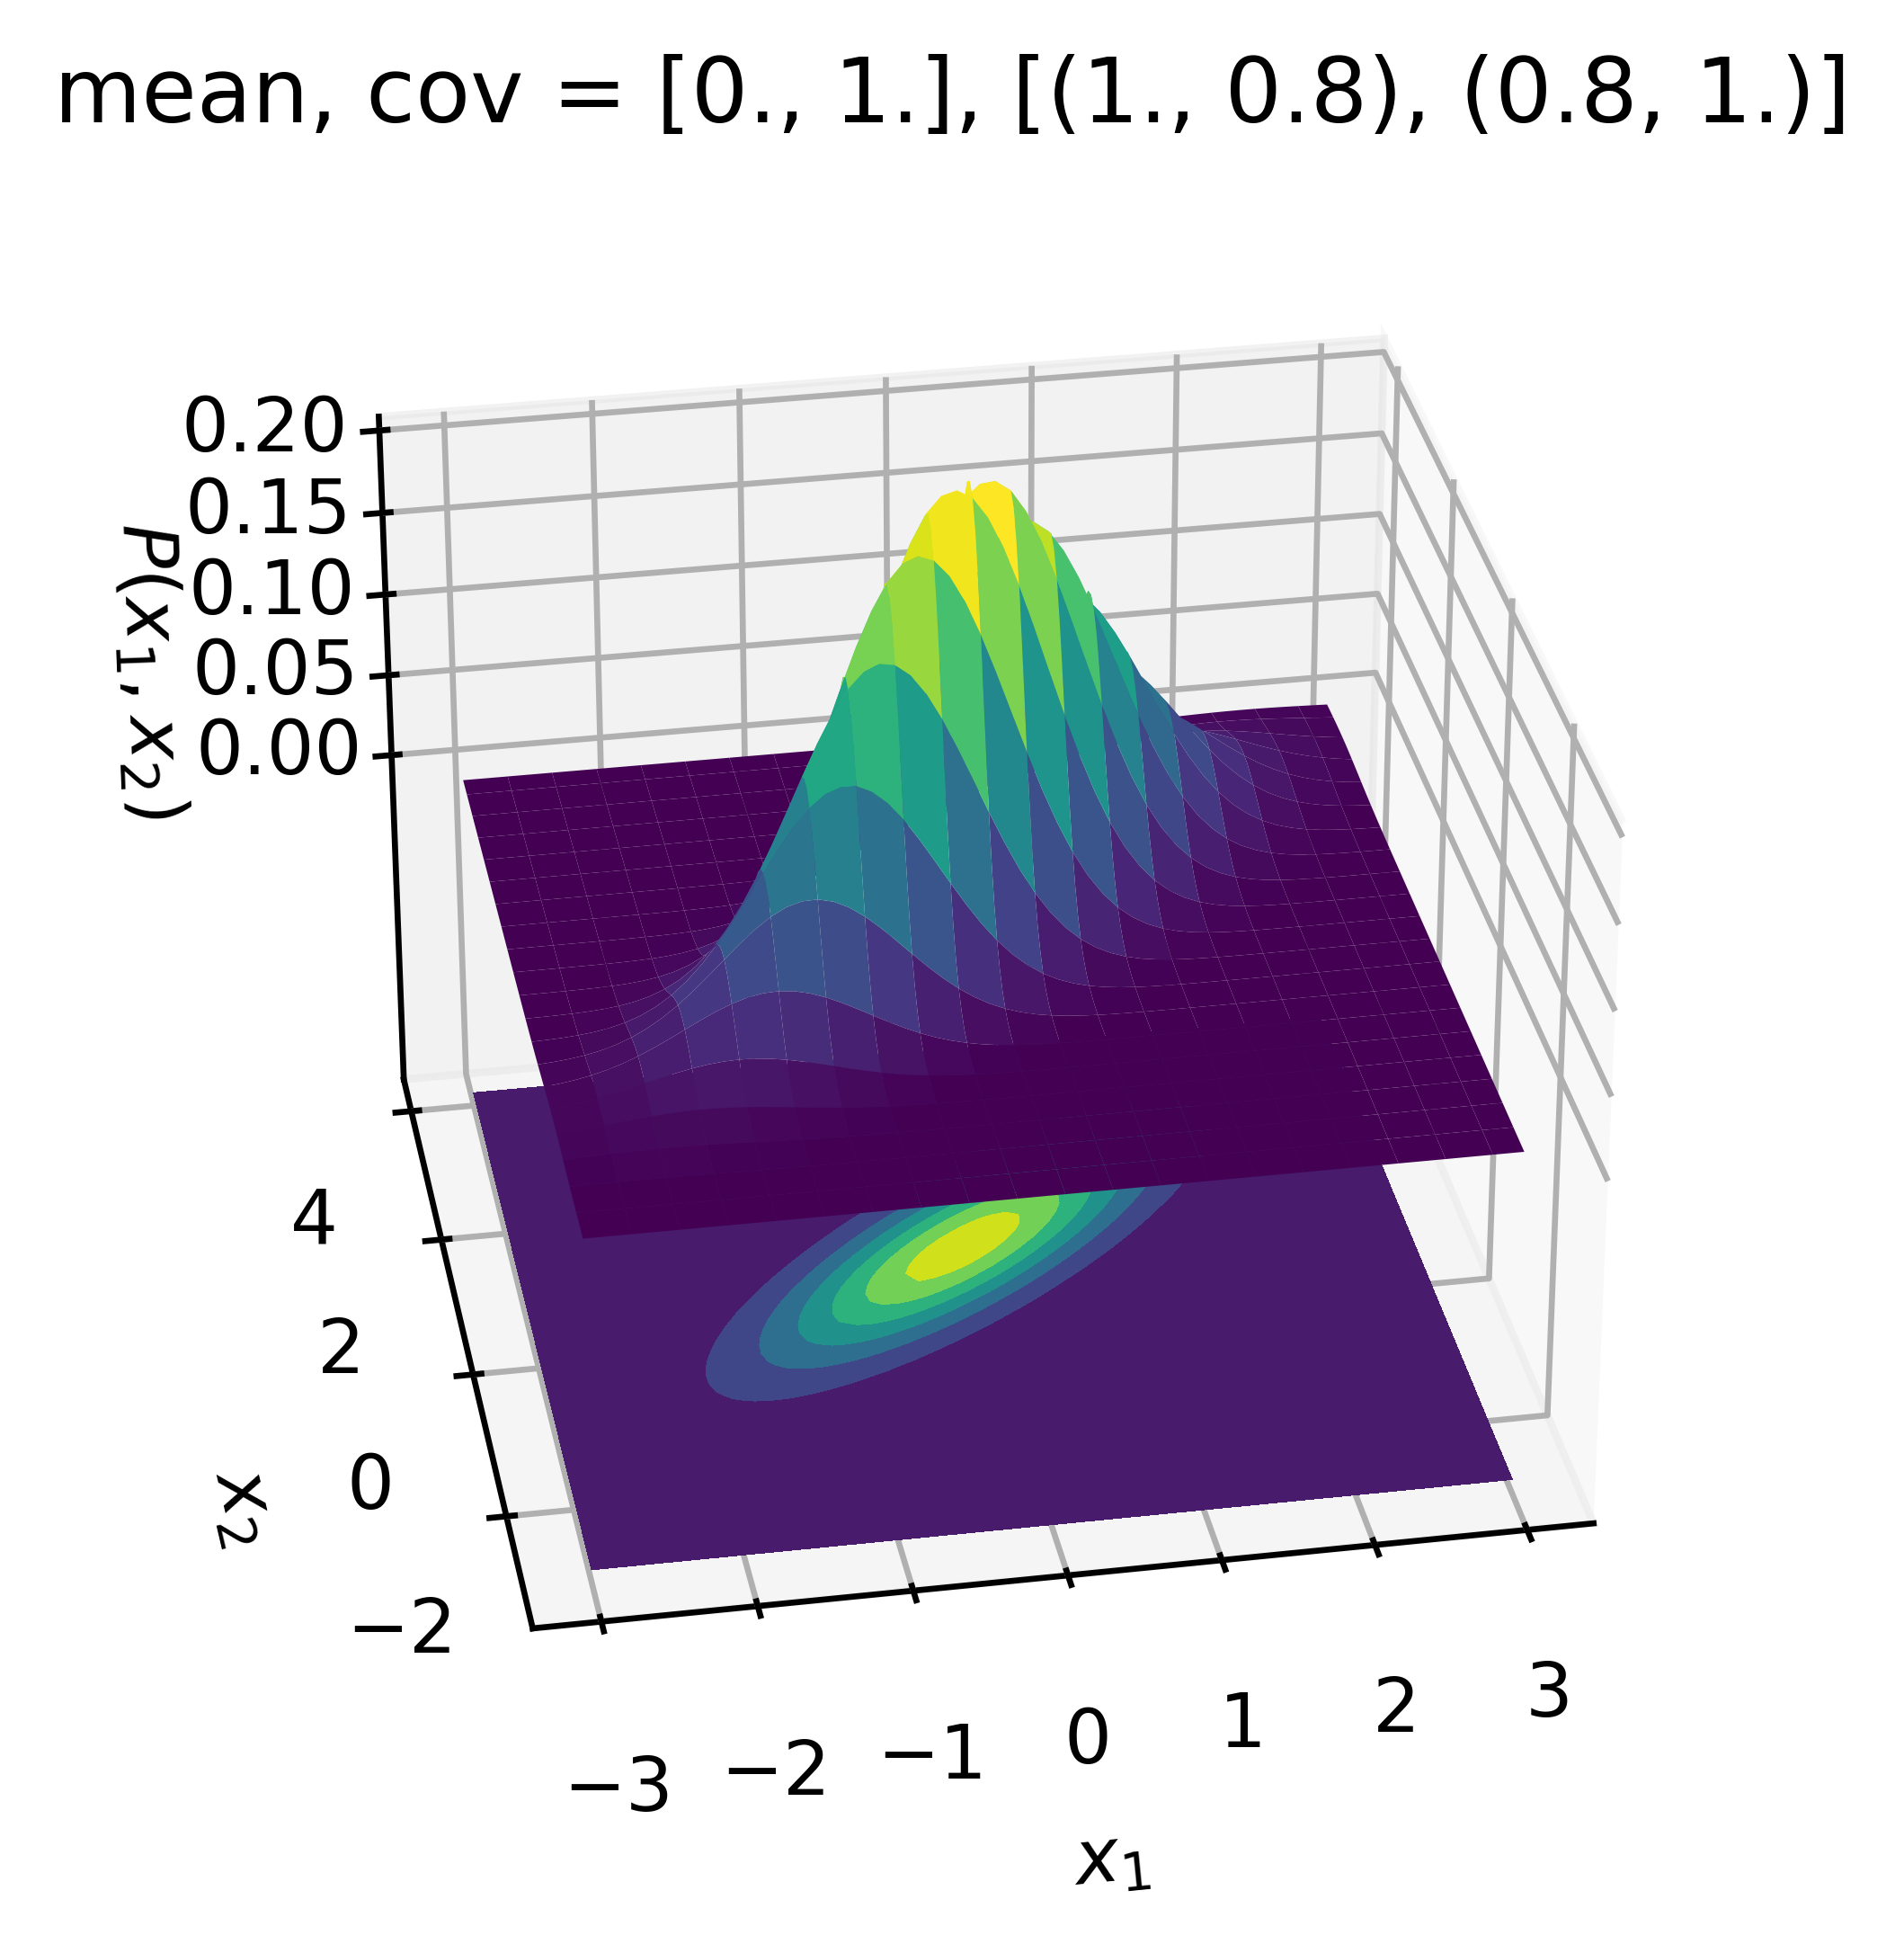

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , 0.8], [0.8,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.2, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.2,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(30, -100)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$P(x_1, x_2)$')

plt.title('mean, cov = [0., 1.], [(1., 0.8), (0.8, 1.)]')
plt.savefig('2d_gaussian3D_0.8.png', dpi=600)
plt.show()

图 5(a) 具有高度的 3-d 钟形曲面，高度代表概率密度

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


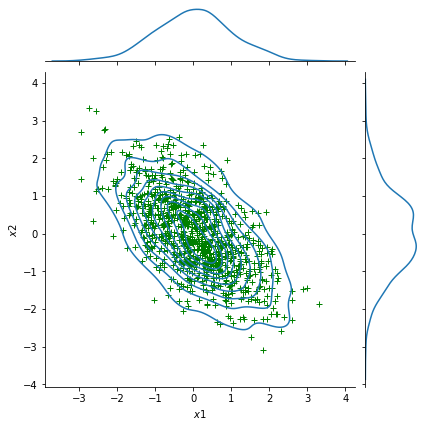

In [9]:
import pandas as pd
import seaborn as sns

mean, cov = [0., 0.], [(1., -0.6), (-0.6, 1.)]
data = np.random.multivariate_normal(mean, cov, 1000)
df = pd.DataFrame(data, columns=["x1", "x2"])
g = sns.jointplot("x1", "x2", data=df, kind="kde")

#(sns.jointplot("x1", "x2", data=df).plot_joint(sns.kdeplot))

g.plot_joint(plt.scatter, c="g", s=30, linewidth=1, marker="+")

#g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$x1$", "$x2$");

#g.ax_joint.legend_.remove()
plt.show()

图 5(b) 二元高斯分布的平面投影，椭圆轮廓投影显示随机变量 $x_1$ 和 $x_2$ 的样本点之间的相关关系

对于回归任务而言，除了上述联合概率分布 $P$ 外，我们更需要条件概率分布，如图 5 所示，在三维钟形曲面上切开一个切片，得到图 6 所示的条件概率分布 $P(x_1|x_2)$。此外，根据多元高斯分布理论，该条件分布也是高斯分布[11]。

<div id="image-table">
    <table>
	    <tr>
    	    <td style="padding:10px">
        	    <img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2d_gaussian_conditional3D.png?raw=1" width="400"/>
            </td>
            <td style="padding:10px">
            	<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2d_gaussian_conditional.png?raw=1" width="300"/>
            </td>
        </tr>
    </table>
</div> 

图 6 二元高斯分布的条件概率分布

对于 $N$ 维高斯分布，不同之处仅在于：协方差矩阵 $\Sigma$ 是 $N×N$ 的，并且其第 $(i,j)$ 个维度之间的相关性 $\Sigma_{ij}=cov(y_i,y_j)$， 协方差矩阵 $\Sigma$ 是一个对称矩阵，保存了所有维度随机变量之间的两两协方差。

有关多元高斯分布的更多可视化示例，可以参见[Multivariante Gaussians and Mixtures of Gaussians (MoG)](https://www.cs.toronto.edu/~guerzhoy/411/lec/W08/MoG.html) 。

### 2.3 核函数

根据前述分析（见图 4）， 我们希望高斯过程分布的函数样本足够平滑，解决办法就是为相邻的随机变量定义合适的协方差关系，而协方差函数是定义协方差关系的有力工具。在高斯过程回归中，协方差函数是唯一能够反映我们所建模函数形式的先验知识。在回归任务中，当两个输入彼此接近时，函数的输出值也应该相似。

一种可能的方程形式是点积 $A \cdot B=\|A\|\|B\| \cos \theta$，其中 $\theta$ 表示两个输入向量的夹角。 两个输入向量越相似，则它们点积的输出值越高。

当一个算法仅根据输入空间中的内积 $<x,x'>$ 即可定义时，则通过某个函数 $k(x,x')$ 对内积 $<x,x'>$ 进行替换，就可以将该算法转换到特征空间中，进而在特征空间中使问题得到简化和解决。此时称函数 $k(\bullet,\bullet)$ 为核函数 [1]。最广泛使用的核函数（或协方差函数）是平方指数核函数。它是高斯过程事实上的默认内核，因为其普遍性质可以对大多数你需要的函数进行积分，而且其先验中的每个函数都有无限多导数。平方指数核函数也被称为径向基函数 (RBF) 或高斯核函数，其不含超参数的简化定义为：

$$
cov(x_i, x_j)=\exp\left(-~\frac{(x_i-x_j)^2}{2}\right)
$$

在 `图 4(b)` 中，我们曾经绘制了 20 个独立高斯向量（各向量由随机抽样的 10 个样本构成），并通过连接相邻向量间样本点的方式，构造了 10 条折线。此处，我们换一种做法，不再从 20 个独立高斯变量中分别抽取各自的 10 个样本， 而是如 `图 7(a)` 所示，在一个协方差矩阵为单位矩阵的 20 维高斯分布中抽取 10 个样本。由于不同维度之间相关性为 0， 即不同高斯随机变量之间没有相关性，所以其与图 4(b) 相同，也显得非常杂乱。但当使用径向基函数作为协方差函数时，则可以得到`图 7(b)` 所示的平滑曲线。

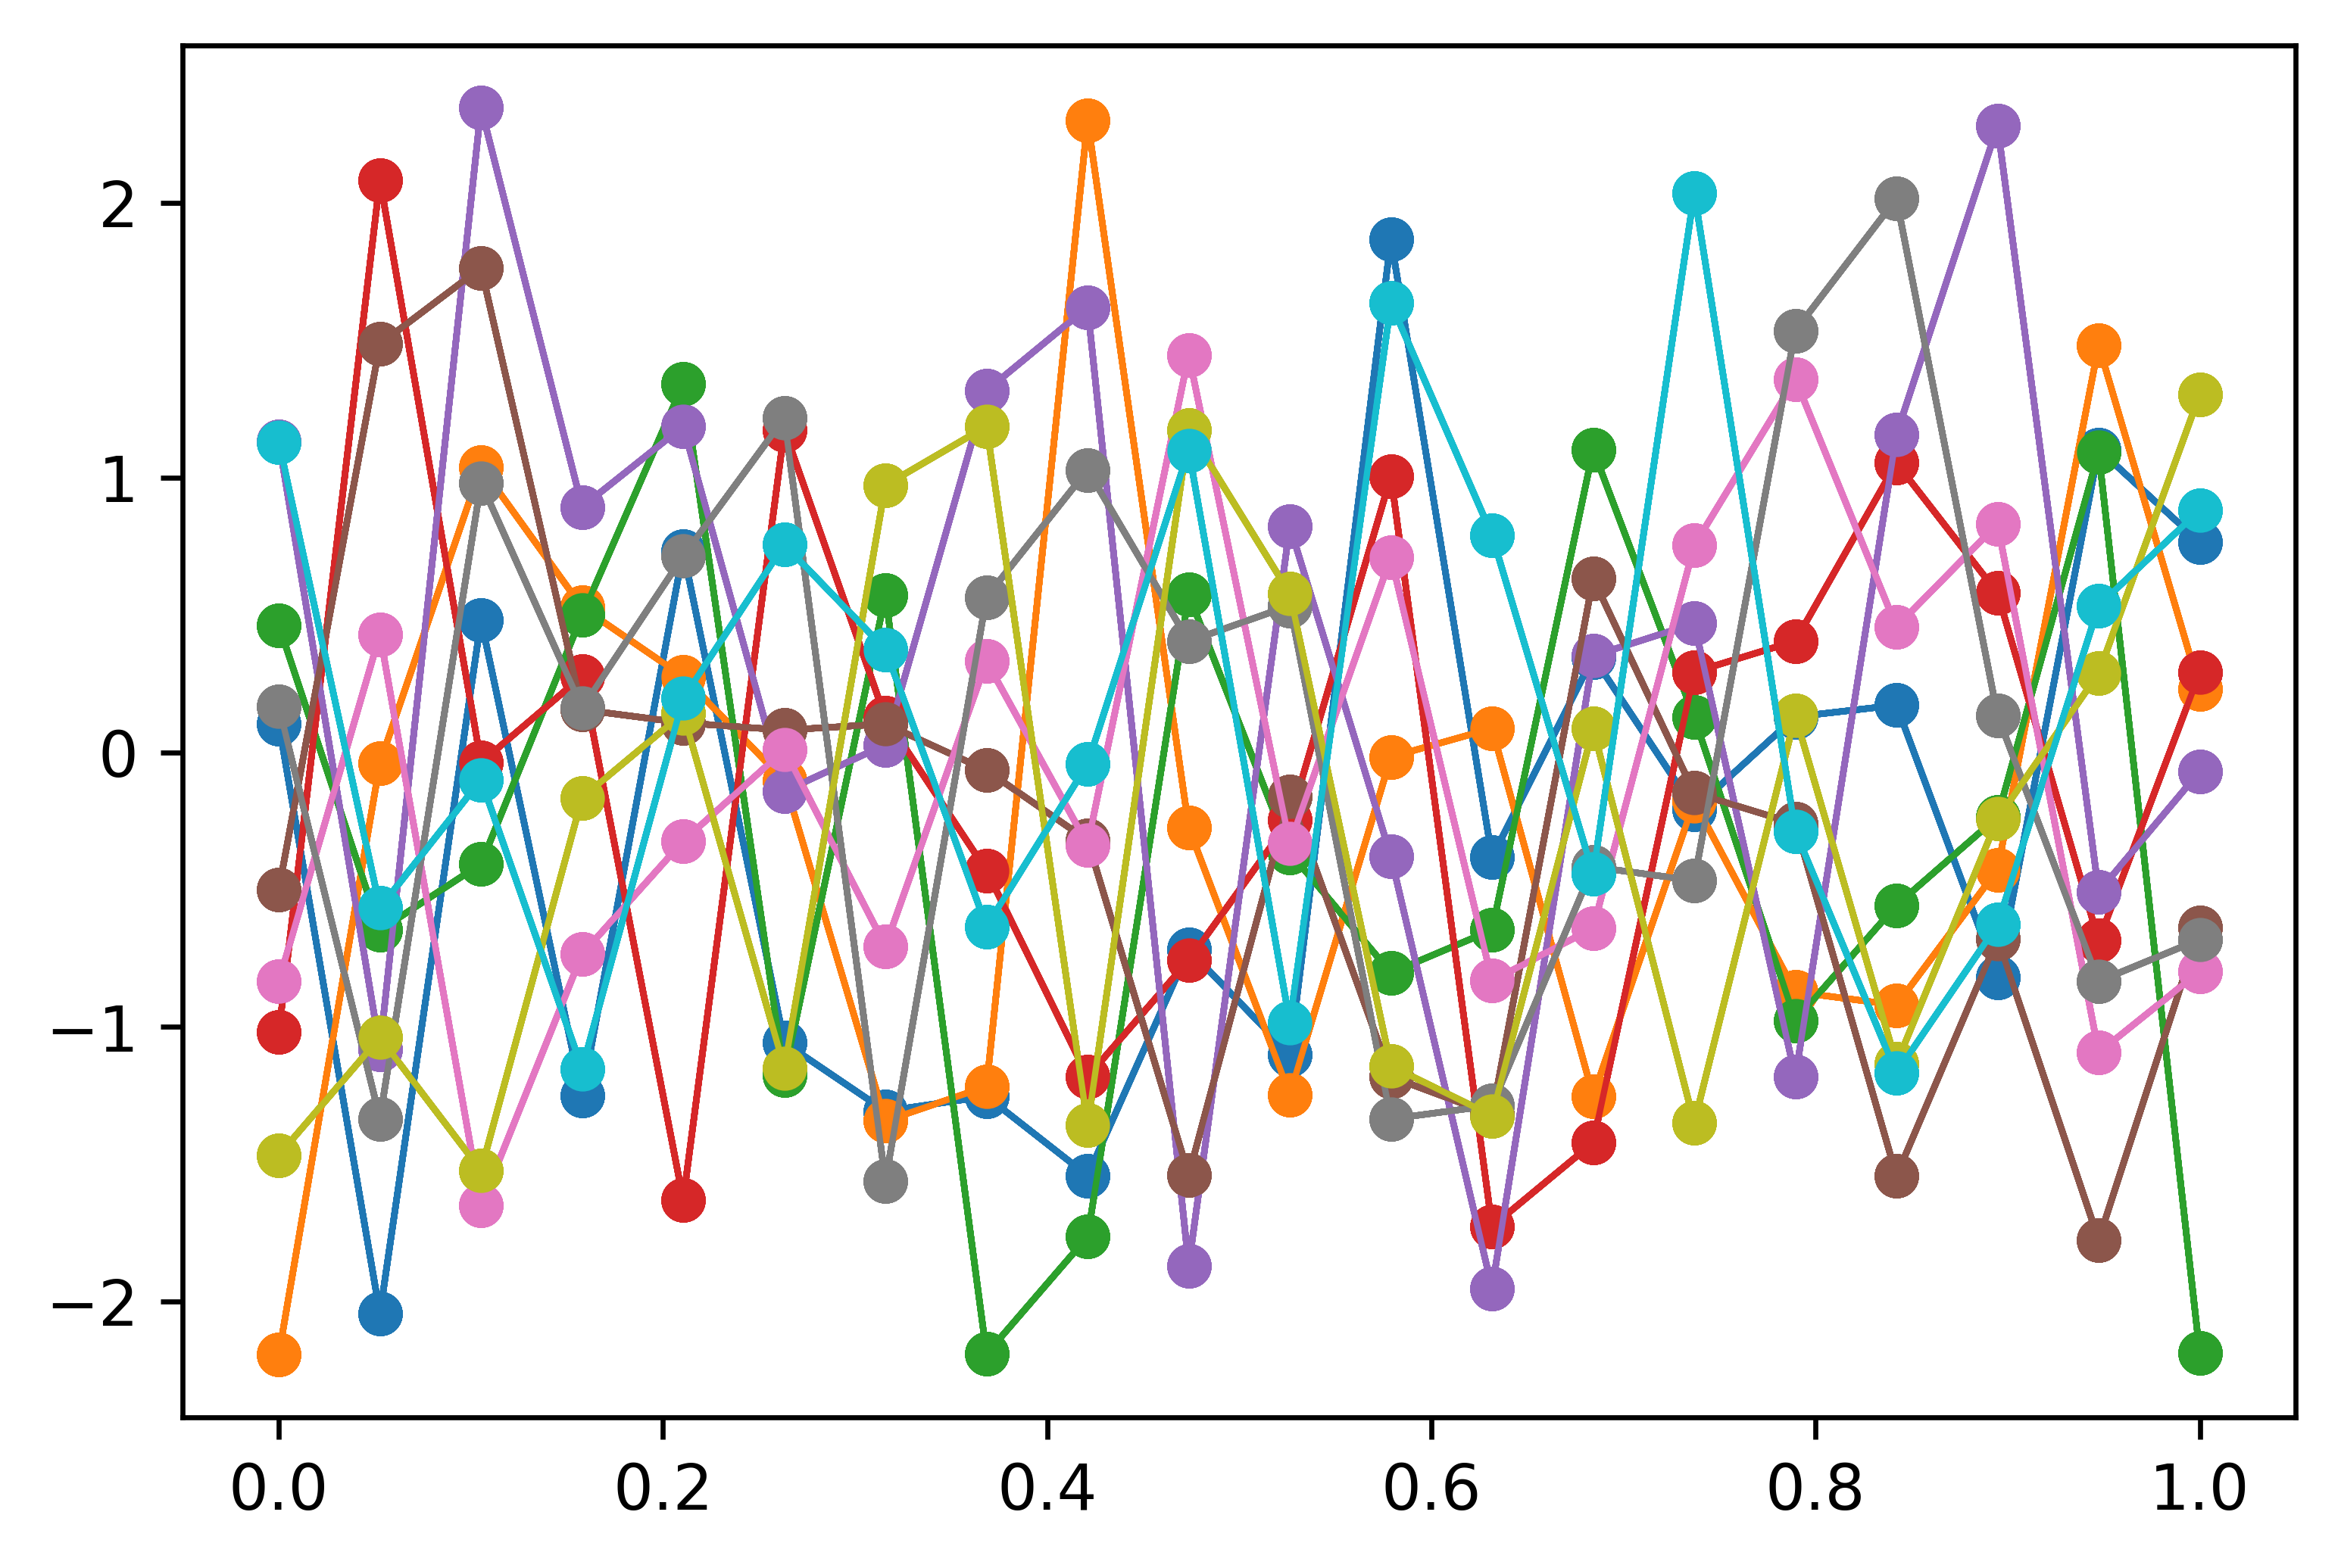

In [10]:
n = 20 
m = 10

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, cov, m).T

plt.clf()

#plt.plot(Xshow, f_prior, '-o')
Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
# plt.title('10 samples of the 20-D gaussian prior')
# plt.show()
plt.savefig('20d_gaussian_prior')

图 7a 采用单位协方差矩阵抽取的 10 组样本，每组样本构成一个可能的函数，由于不同维度之间相关性为 0，所以函数曲线依然显得很杂乱

In [11]:
# Define the kernel
def kernel(a, b):
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return np.exp(-.5 * sqdist)

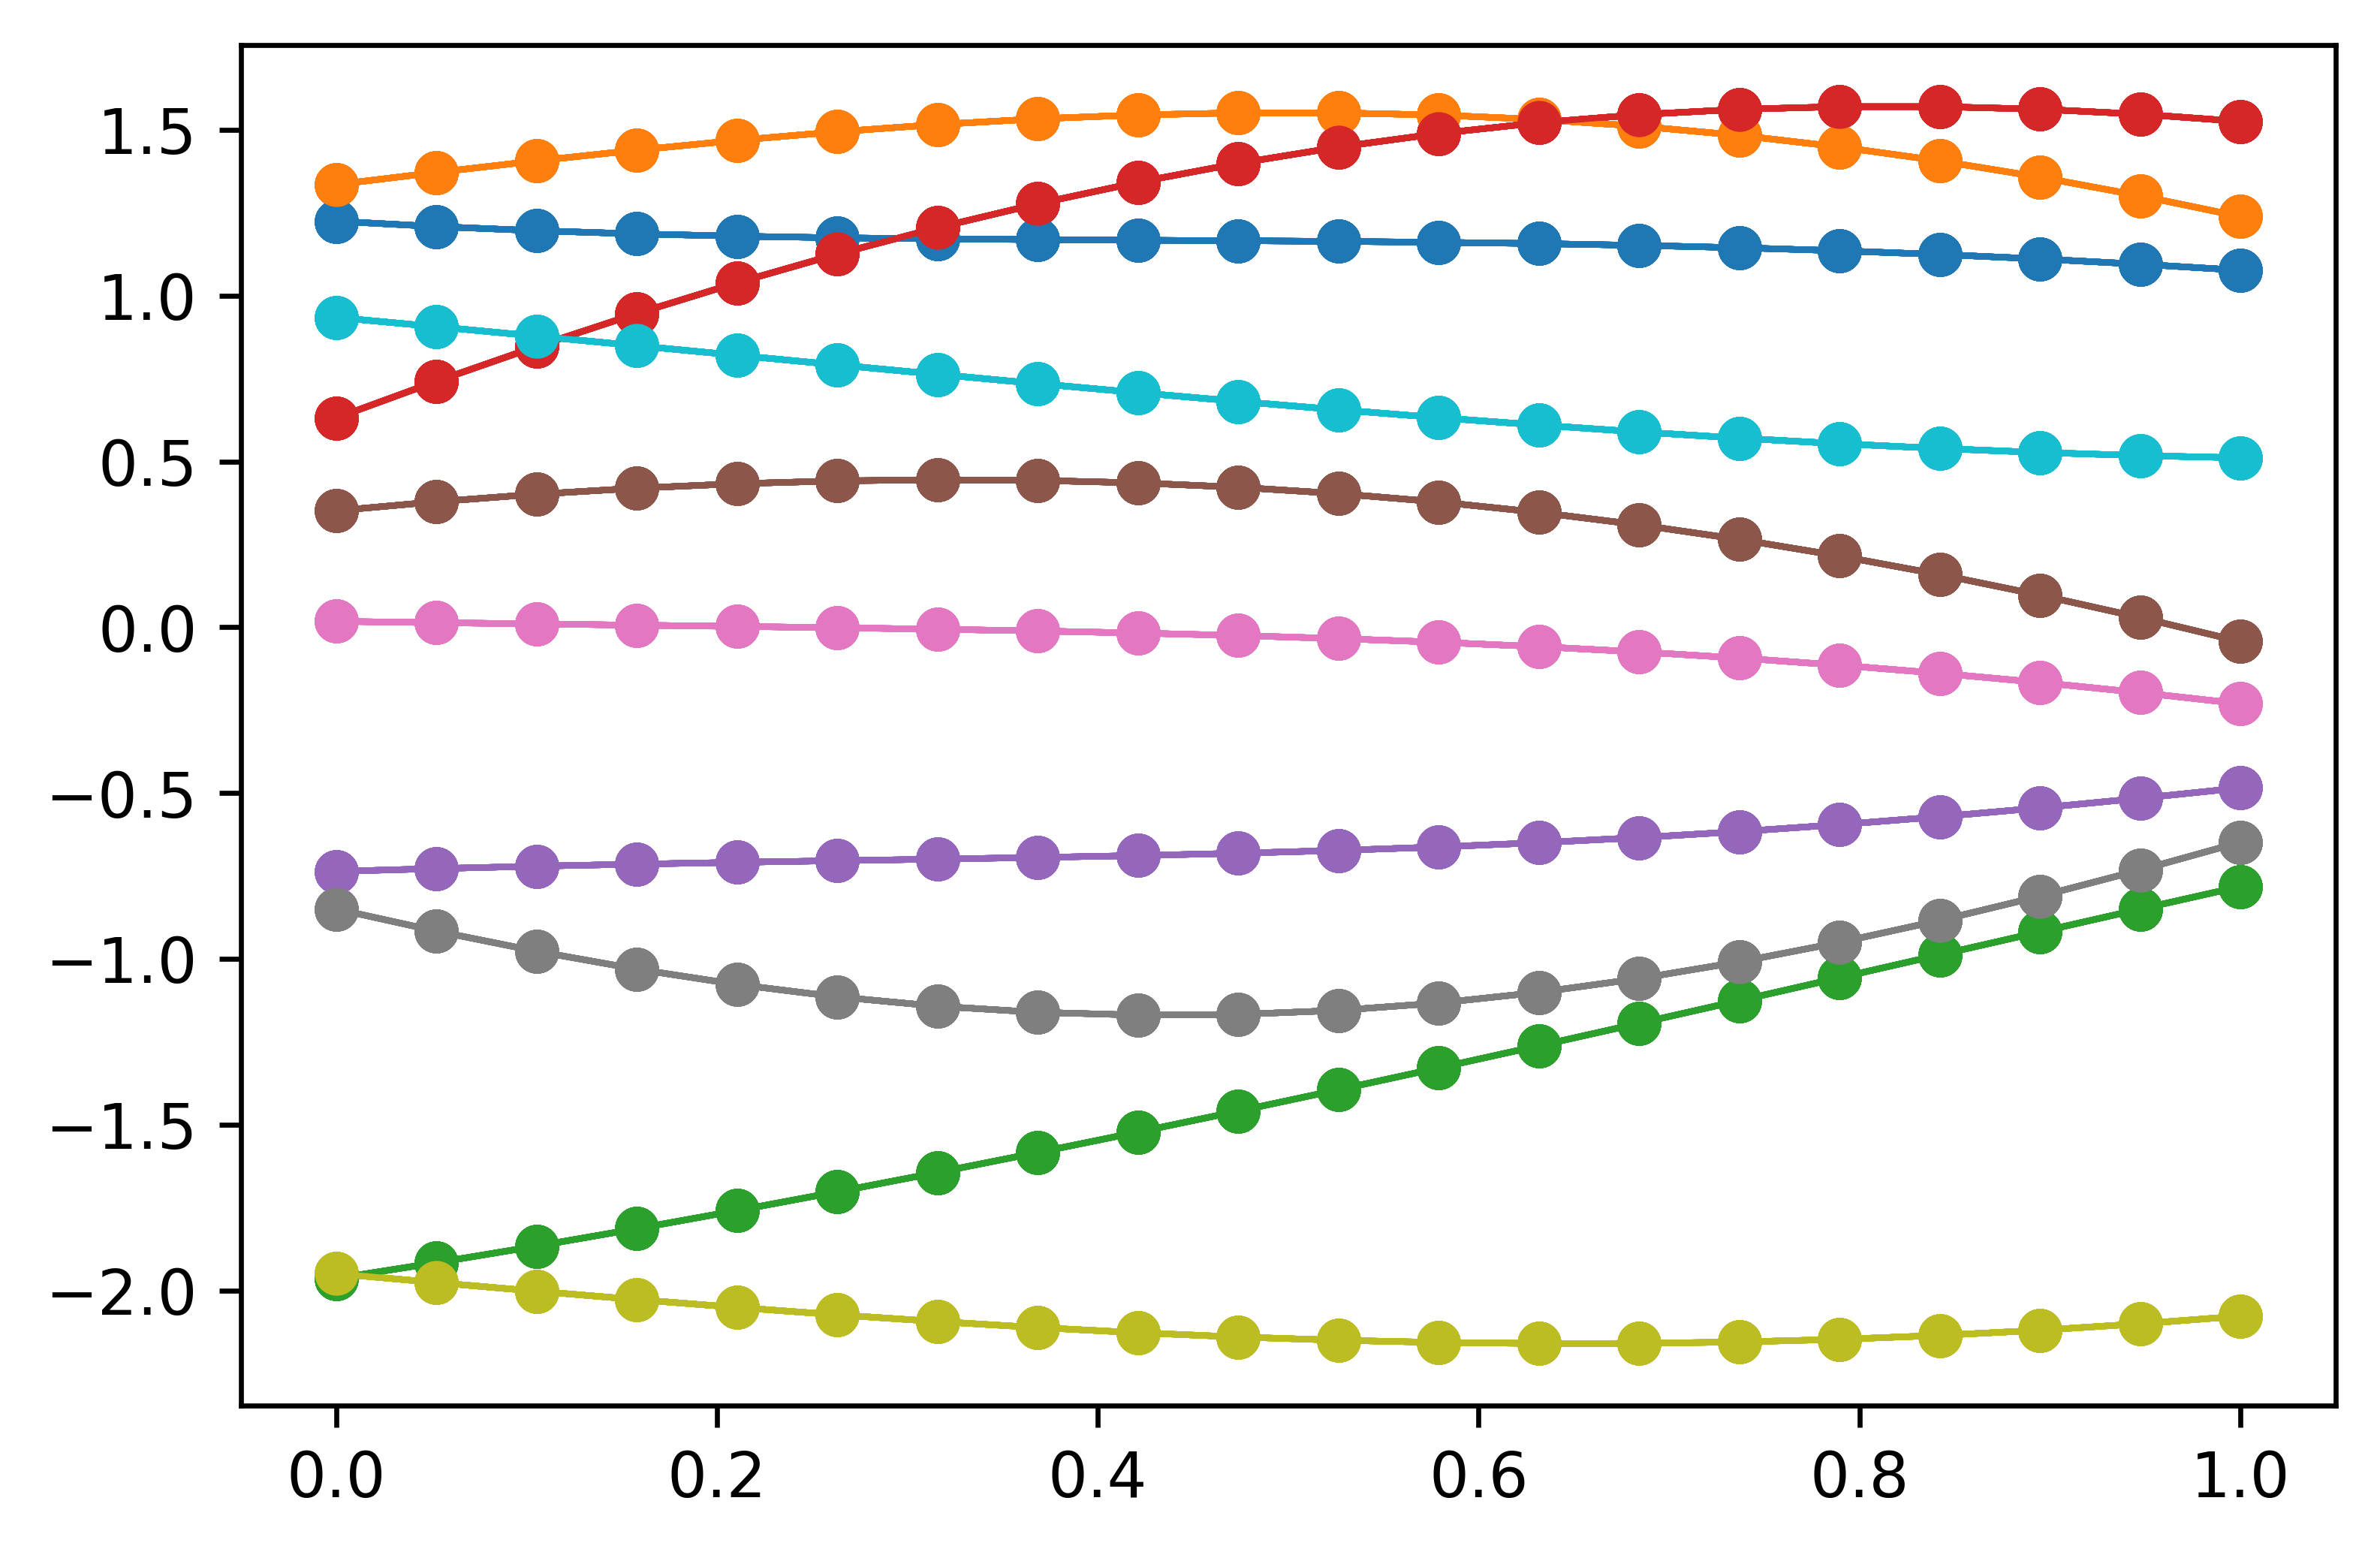

In [12]:
n = 20  
m = 10

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

K_ = kernel(Xshow, Xshow)                  # k(x_star, x_star)        

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, K_, m).T

plt.clf()

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
# plt.title('10 samples of the 20-D gaussian kernelized prior')
# plt.show()
plt.savefig('20d_gaussian_kernel_prior')

图 7b 采用径向基函数作为协方差函数抽取的 10 组样本，由于不同维度之间设置了相关关系，使得函数曲线显得较为平滑

图 7 表明，通过添加协方差函数，我们可以获得更平滑的线条，使其看起来更像函数的样子了。因此，进一步考虑增加高斯多元分布的维度就显得很自然了。此处的维数是指多元高斯分布中随机变量的个数，所以当多元高斯分布的维数变大时，兴趣区域内就会被更多点填满，而当维度变为无穷大时，任何可能的输入就都能找到一个点来代表。

通过使用无限维的多元高斯分布，理论上可以拟合具有无穷多参数的任意复杂函数，并在兴趣区域内的任何地方执行预测任务。图 8 绘制了一个 200 维高斯分布的 200 个样本，以感性认识具有无穷多参数的函数（意即样本数量可以有无穷个，而我们仅抽取了其中 200 个）。这些函数被称为`核化先验函数`，因为此时尚未引入样本点。所有抽取的函数样本都是在引入任何样本点之前，由结合了核函数的多元高斯分布作为先验随机生成的。

In [13]:
n = 200         
m = 200

Xshow = np.linspace(0, 1, n).reshape(-1,1)   

K_ = kernel(Xshow, Xshow)                    # k(x_star, x_star)        

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, K_, m).T

plt.clf()
#plt.plot(Xshow, f_prior, '-o')
Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.figure(figsize=(16,8))
for i in range(m):
    plt.plot(Xshow, f_prior, 'o', linewidth=1, markersize=2, markeredgewidth=1)
    
plt.title('200 samples of the 200-D gaussian kernelized prior')
#plt.axis([0, 1, -3, 3])
plt.show()
#plt.savefig('priorT.png', bbox_inches='tight', dpi=300)

<Figure size 3600x2400 with 0 Axes>

图 8 从 200 维高斯分布中抽取的 200 个核化先验函数（即200条曲线）

根据上图可知，当多元高斯分布推广到无限维时，我们可以在兴趣区内对所有可能的点进行采样。

一个非常好的展示动画，分别展示了二个样本点和四个样本点时的协方差[10].

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/2points_covariance.gif?raw=1" width="600"/>
      	  
<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/4points_covariance.gif?raw=1" width="600"/>

---

### 2.4 非参数模型

本节解释参数和非参数模型的概念 [13]。

**（1）参数模型**

参数模型假设数据的分布可以用一组有限数量的参数进行建模。在回归任务中，给定一些数据点，我们想用新的 $x$ 对函数 $y=f(x)$ 的值进行预测。如果假设是线性回归模型，$y=θ_1+θ_2x$，则需要找到参数 $θ_1$ 和 $θ_2$ 来定义函数。在很多情况下，线性模型假设不成立，则需要一个参数更多的模型，比如多项式模型 $y=θ_1+θ_2x+θ_3x^2$。

我们使用具有 $n$ 个样本点的训练数据集 $D$ （ $D= [(x_i,y_i)|i=1, . . . ,n] $） 来训练模型，即通过函数 $f(x)$ 建立 $x$ 到 $y$ 的映射。在完成训练后，假设数据的所有信息都已经被参数所捕获，则预测可以独立于训练数据集 $D$ 进行。这种情况可表示为 $P(f_∗|X_∗,`,D) =P(f_∗|X_∗,`)$，其中 $f_∗$ 是在新的数据点 $X_∗$ 上做出的预测。

根据参数模型的定义可知，当使用参数模型作回归时，模型的复杂性（或灵活性）会受到参数数量的限制。

**（2）非参数模型**

如果模型的参数数量不固定，会随着样本数据集的大小而变化，则该模型是一个非参数模型。根据概念，非参数模型并非指模型没有参数，而是指模型的参数数量不固定，甚至可能是无限个参数。

---

注意：为生成具有相关性的高斯分布样本，你可以先生成独立样本（即不相关），然后与矩阵 $L$ 相乘， $LL^T = K$， 其中 $K$ 是期望的协方差矩阵，而 $L$ 则可以用 $K$ 的 Cholesky 分解生成。

In [ ]:
n = 20      
m = 10

Xshow = np.linspace(0, 1, n).reshape(-1,1)  # n number test points in the range of (0, 1)

K_ = kernel(Xshow, Xshow)                

L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))


f_prior = np.dot(L, np.random.normal(size=(n,m)))

plt.clf()
plt.plot(Xshow, f_prior, '-o')
plt.title('10 samples of the 20-D gaussian kernelized prior')
plt.show()

---

## 3 高斯过程

在解释高斯过程之前，先快速回顾一下之前涵盖的基本概念。在回归任务中，在给定训练数据集 $D$ 时，我们期望对函数 $f$ 建模。传统的非线性回归方法通常会给出一个被认为最适合数据集的函数。然而，这样的函数可能不止一个。而在上一节中，我们看到，当多元高斯分布是无限维时，可以用无限数量的函数对任意点作出预测。根据先验假设，这些函数就是多元高斯分布。

通俗的说，这些无穷多函数的先验分布就是多元高斯分布。先验分布表示在没有观测到任何数据的情况下，输入 $x$ 后 $f$ 的预期输出。实践中，当开始观测时，我们只保留适合观测数据点的函数，而并非无限数量的函数。于是就有了后验，也就是用观测数据更新的先验。当有新观测时，在将当前后验作为先验，并使用新观测的数据点来获得新的后验。

这样，我们就有了高斯过程的定义： 高斯过程模型是能够拟合一组点的所有可能函数的概率分布。

因为有了关于所有可能函数的概率分布，我们就可以计算均值来作为函数，计算方差来表明预测的可信度。关键点总结为：

（1）函数（后验）随着新观测值更新；

（2）高斯过程模型是可能函数的概率分布，并且函数的任何有限个样本服从联合高斯分布；

（3）通过可能函数的后验分布计算得到的均值函数，才是最终用于预测的函数。

***A Gaussian process is a probability distribution over possible functions that fit a set of points.***

现在是时候描述标准的高斯过程模型了。所有参数定义均遵循经典教科书[1]。除了基本概念外，特别建议阅读[1]的附录 `A.1` 和 `A.2` 。由多元高斯模型建模的回归函数为：

$$
p(\mathbf{f} \, \lvert\, \mathbf{X}) = \mathcal{N}(\mathbf{f} \, \lvert\, \boldsymbol\mu, \mathbf{K})
$$

其中 $\mathbf{X}=[x_1,...,x_n]$， $\mathbf{f} = [f(\mathbf{x}_1),...,f(\mathbf{x}_n)]$， $\boldsymbol\mu = [m(\mathbf{x}_1),...,m(\mathbf{x}_n)]$ 且 $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$。 $\mathbf{X}$ 为观测数据点，$m$ 代表均值函数，$\kappa$ 代表正定核函数。在没有观测数据的情况下，均值函数默认为 $m(\mathbf{X}) = 0$ （因为数据通常会作归一化处理，均值为零）。高斯过程模型是函数的分布，其形状（平滑度）由 $\kappa$ 定义。 因此如果点 $\mathbf{x}_i$ 和 $\mathbf{x}_j$ 被核认为相似，则两个点处的 $f(x_i)$ 和 $f(x_j)$ 函数的输出应该也相似。

高斯过程模型进行回归的过程如`图 9` 所示： 给定观测数据（红点）和由这些观测数据估计的平均函数 $\mathbf{f}$（蓝线），对于新的一些点 $\mathbf{X}_*$，我们的任务是预测 $f(\mathbf{X}_*)$ 。

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/mvn.png?raw=1" width="250"/> 

图9：高斯过程回归的说明性过程。红点为观测数据，蓝线表示观测数据点估计的均值函数，在新的蓝点处进行预测。

如果进行预测呢？

根据前述介绍，可以将 $\mathbf{f}$ 和 $\mathbf{f}_*$ 的联合分布建模为：

$$
 \begin{pmatrix}\mathbf{f} \\ \mathbf{f}_*\end{pmatrix} \sim\mathcal{N}\left(\begin{pmatrix}m(\mathbf{X})\\ m(\mathbf{X}_*)\end{pmatrix}, \begin{pmatrix}\mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}\right) 
$$

其中 $\mathbf{K}=\kappa(\mathbf{X}, \mathbf{X})$, $\mathbf{K}_* = \kappa(\mathbf{X}, \mathbf{X}_*)$ 且 $\mathbf{K}_{**}=\kappa(\mathbf{X}_*, \mathbf{X}_*)$。此外， $\begin{pmatrix}m(\mathbf{X})\\ m(\mathbf{X}_*)\end{pmatrix} = \mathbf{0}$。

这是在 $\mathbf{f}$ 和 $\mathbf{f}_*$ 上的联合概率分布公式 $p(\mathbf{f}, \mathbf{f}_* \, \vert \, \mathbf{X}, \mathbf{X}_*)$, 但是，回归任务只需要获得 $\mathbf{f}_*$ 上的条件概率分布 $p(\mathbf{f}_* \, \vert \, \mathbf{f}, \mathbf{X}, \mathbf{X}_*)$ 即可。从联合概率分布 $p(\mathbf{f}, \mathbf{f}_* \, \vert \, \mathbf{X}, \mathbf{X}_*)$ 推导条件概率分布 $p(\mathbf{f}_* \, \vert \, \mathbf{f}, \mathbf{X}, \mathbf{X}_*)$ 可以使用**多元高斯分布的边缘概率和条件概率公式**[5]。

---
定理：多元高斯分布的边缘和条件概率公式
 
假设 $X=\left(x_{1}, x_{2}\right)$ 为联合高斯分布，其参数为：

$$
\mu=\left(\begin{array}{l}
\mu_{1} \\
\mu_{2}
\end{array}\right), \boldsymbol{\Sigma}=\left(\begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array}\right), \Lambda=\boldsymbol{\Sigma}^{-1}=\left(\begin{array}{ll}
\boldsymbol{\Lambda}_{11} & \boldsymbol{\Lambda}_{12} \\
\boldsymbol{\Lambda}_{21} & \boldsymbol{A}_{22}
\end{array}\right)
$$

则 $x_1$ 和 $x_2$ 的边缘分布为：

$$
\begin{aligned}
&p\left(x_{1}\right)=\mathcal{N}\left(x_{1} \mid \mu_{1}, \boldsymbol{\Sigma}_{11}\right) \\
&p\left(\boldsymbol{x}_{2}\right)=\mathcal{N}\left(x_{2} \mid \boldsymbol{\mu}_{2}, \boldsymbol{\Sigma}_{22}\right)
\end{aligned}
$$

并且后验条件概率为：

$$
\begin{aligned}
p\left(x_{1} \mid x_{2}\right) &=\mathcal{N}\left(x_{1} \mid \mu_{1 \mid 2}, \Sigma_{1 \mid 2}\right) \\
\mu_{1 \mid 2} &=\mu_{1}+\Sigma_{12} \Sigma_{22}^{-1}\left(x_{2}-\mu_{2}\right) \\
&=\mu_{1}-\Lambda_{11}^{-1} \Lambda_{12}\left(x_{2}-\mu_{2}\right) \\
&=\Sigma_{1 \mid 2}\left(\Lambda_{11} \mu_{1}-\Lambda_{12}\left(x_{2}-\mu_{2}\right)\right) \\
\Sigma_{1 \mid 2} &=\Sigma_{11}-\Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}=\Lambda_{11}^{-1}
\end{aligned}
$$

---

由此，我们可以得到如下条件公式 [1] ：

$$
\mathbf{f}_* \, \vert \, \mathbf{f}, \mathbf{X}, \mathbf{X}_* \sim \mathcal{N} (\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{f}, \: \mathbf{K}_{**}-\mathbf{K}_*^T \mathbf{K}^{-1} \mathbf{K}_*) 
$$

在更现实的情况下，我们无法访问真正的函数值 $f(x)$，但可以获得其含噪声版本 $y = f(x) + \epsilon$。假设存在具有方差为 $\sigma_n^2$ 的加性独立同分布高斯噪声，则带噪声观测的先验变为 $cov(y) = \mathbf{K} + \sigma_n^2\mathbf{I}$ 。观测值与新测试点的函数值的联合分布变为：

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim\mathcal{N}\left(\mathbf{0}, \begin{pmatrix}\mathbf{K} + \sigma_n^2\mathbf{I} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}\right) 
$$

通过使用多元高斯分布的条件分布公式，可以得到高斯过程回归的预测方程为：

$$
\mathbf{\bar{f}_*} \, \vert \, \mathbf{X}, \mathbf{y}, \mathbf{X}_* \sim \mathcal{N} \left(\mathbf{\bar{f}_*}, cov(\mathbf{f}_*)\right) 
$$

其中：

$$
\mathbf{\bar{f}_*} \overset{\Delta}{=} \mathbb{E} [\mathbf{\bar{f}_*} \, \vert \, \mathbf{X}, \mathbf{y}, \mathbf{X}_*] \\= \mathbf{K}_*^T [\mathbf{K} + \sigma_y^2\mathbf{I}]^{-1} \mathbf{y} 
$$

$$
cov(\mathbf{f}_*) = \mathbf{K}_{**} - \mathbf{K}_*^T [\mathbf{K} + \sigma_y^2\mathbf{I}]^{-1} \mathbf{K}_* 
$$

分析方差函数 $cov(f_∗)$ ，可以注意到方差不依赖于观察到的输出 $\mathbf{y}$，而只依赖于输入 $\mathbf{X}$ 和 $\mathbf{X}_∗$。这是高斯分布的一个性质[13]。

## 4 简单的实现案例

本节展示一个标准的高斯过程回归实现。该示例遵循[11]中第 19 页的算法：

$$
\begin{aligned}
L &=\operatorname{cholesky}\left(K+\sigma_{n}^{2} I\right) \\
\alpha &=L^{\top} \backslash(L \backslash \mathbf{y}) \\
\bar{f}_{*} &=\mathbf{k}_{*}^{\top} \boldsymbol{\alpha} \\
\mathbf{v} &=L \backslash \mathbf{k}_{*} \\
\mathbb{V}\left[f_{*}\right] &=k\left(\mathbf{x}_{*}, \mathbf{x}_{*}\right)-\mathbf{v}^{\top} \mathbf{v} . \\
\log p(\mathbf{y} \mid X) &=-\frac{1}{2} \mathbf{y}^{\top}\left(K+\sigma_{n}^{2} I\right)^{-1} \mathbf{y}-\frac{1}{2} \log \operatorname{det}\left(K+\sigma_{n}^{2} I\right)-\frac{n}{2} \log 2 \pi \\
\hline
\end{aligned}
$$

算法输入是 $X$（样本输入）、$\mathbf{y}$（样本输出）、$k$（协方差函数）、$\sigma_{n}^{2}$（加性噪声的水平）和 $\mathbf{x}_∗$（测试输入）。 算法输出是̄ $f_∗$（平均值）、$\mathcal{V}[f_∗]$（方差）和 $logp（\mathbf{y}|X）$（对数边缘似然）。

如图 10 所示。我们在感兴趣的 [-5, 5] 区间内进行了回归。观察到的数据点（训练数据集）是从 -5 和 5 之间的均匀分布中生成的。这意味着在给定区间 [-5,5] 内的任意一个点的值都有可能被均匀抽取。这些函数将在 -5 和 5 之间的 `n` 个均匀间隔点处进行评估。这样做是为了在感兴趣的区域 [-5, 5] 中显示用于回归的连续函数。这是一个做高斯过程回归的简单例子，它假定高斯过程先验均值为零。此处代码大量借鉴了 Nando de Freitas 博士的[非线性回归高斯过程](https://youtu.be/4vGiHC35j9s) 。回归函数由高斯过程回归模型估计的平均值组成，图中还会绘制了 $3μ$ 方差内的 20 个后验均值函数的样本。

In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
x = np.arange(-5, 5, 0.1)

plt.plot(x, f(x))
plt.axis([-5, 5, -3, 3])
plt.show()

In [ ]:
# Define the kernel
def kernel(a, b):
    kernelParameter_l = 0.1
    kernelParameter_sigma = 1.0
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return kernelParameter_sigma*np.exp(-.5 * (1/kernelParameter_l) * sqdist)

我们使用通用的平方指数核，也称径向基函数或高斯核：

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))
$$

其中 $\sigma_f$ 和 $l$ 为超参数。有关超参数的更多信息，可在代码后找到。

In [ ]:
# Sample some input points and noisy versions of the function evaluated at
# these points. 
N = 20         # number of existing observation points (training points).
n = 200        # number of test points.
s = 0.00005    # noise variance.

X = np.random.uniform(-5, 5, size=(N,1))     # N training points 
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))     # line 1 

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))   # k_star = kernel(X, Xtest), calculating v := l\k_star
mu = np.dot(Lk.T, np.linalg.solve(L, y))    # \alpha = np.linalg.solve(L, y) 

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)                  # k(x_star, x_star)        
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)   
s = np.sqrt(s2)

# PLOTS:
plt.figure(1)
plt.clf()
plt.plot(X, y, 'k+', ms=18)
plt.plot(Xtest, f(Xtest), 'b-')
plt.gca().fill_between(Xtest.flat, mu-2*s, mu+2*s, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
#plt.savefig('predictive.png', bbox_inches='tight', dpi=300)
plt.title('Mean predictions plus 2 st.deviations')
plt.show()
#plt.axis([-5, 5, -3, 3])

In [ ]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,40)))  # size=(n, m), m shown how many posterior  
plt.figure(3)
plt.clf()
plt.figure(figsize=(18,9))
plt.plot(X, y, 'k+', markersize=20, markeredgewidth=3)
plt.plot(Xtest, mu, 'r--', linewidth=3)
plt.plot(Xtest, f_post, linewidth=0.8)
plt.title('40 samples from the高斯过程posterior, mean prediction function and observation points')
plt.show()
#plt.axis([-5, 5, -3, 3])
#plt.savefig('post.png', bbox_inches='tight', dpi=600)

图 10： 标准高斯过程回归的说明性示例。图中已观测的数据点绘制为黑色十字（样本数据集），根据这些数据点，可以获得无限个可能的后验函数。我们用排序的颜色绘制了其中 `m=40` 个函数样本。红色虚线为均值函数，由上述 20 个样本函数及其概率分布计算获得。可以清晰地看到，所有后验函数样本在已观测点处都是收缩的。

### 4.1 超参数的优化

我们解释了高斯过程回归的基础知识并实现了一个简单的例子。虽然不切实际，但高斯过程回归模型比它更复杂。核函数在高斯过程回归中发挥着重要作用。核函数的选择决定了高斯过程模型的几乎所有泛化特性 [4]。根据您的具体问题，有许多协方差函数可供选择或为高斯过程创建自己的协方差函数。这些标准包括模型是否平滑、是否稀疏、是否可以剧烈变化以及是否需要可微[ 5]。有关为高斯过程选择 kernel/协方差函数的更多深度信息，请参见 [5]。在内核中，超参数优化是必不可少的。这里我们将使用最广泛使用的内核 RBF 作为例子来解释超参数优化。一般的 RBF 函数由下式给出：

$$
k\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=\sigma_{f}^{2} \exp \left(-\frac{1}{2 l}\left(\mathbf{x}_{i}-\mathbf{x}_{j}\right)^{\top}\left(\mathbf{x}_{i}-\mathbf{x}_{j}\right)\right)
$$

其中 $\sigma_{f}$ 和 $l$ 为超参数[5]。垂直标度 $\sigma_{f}$ 描述了函数在垂直方向的范围。水平标度 $l$ 表示两点之间的相关关系随着距离增加而下降的速度。 $l$ 的效果如图 11 所示。较高的 $l$ 提供更平滑的函数，较小的 $l$ 提供更摆动的函数。

<img src="https://github.com/jwangjie/Gaussian-Process-be-comfortable-using-it/blob/master/img/hyperparameter.png?raw=1" width="700"/>

图 11  超参数水平标度对函数平滑度的影响

优化的超参数 $Θ^*$ （对径向基函数而言, 超参数 $\mathbf{\Theta} = [\sigma_f, l]$） 通过最大化对数边缘似然[11]确定：  

$$
 \mathbf{\Theta^*} = \arg\max\limits_{\Theta} \log p(y \, \vert \, \mathbf{X}, \mathbf{\Theta}) 
$$ 

因此，考虑到超参数，在新测试点的更一般的预测方程是 [2]

$$
\mathbf{\bar{f}_*} \, \vert \, \mathbf{X}, \mathbf{y}, \mathbf{X}_*,  \mathbf{\theta} \sim \mathcal{N} \left(\mathbf{\bar{f}_*}, cov(\mathbf{f}_*)\right) 
$$

请注意，在学习/调整超参数后，预测方差 $cov(\mathbf{f}_*)$ 不仅取决于样本和测试输入 $\mathbf{X}$ 和 $\mathbf{X}^*$, 还取决于样本输出 $\mathbf{y}$ [1]。优化后的超参数 $σ_f=0.0067$ 和 $l=0.0967$， 图 11 中观测数据点的回归结果见图 12 。

更多有关超参数估计的直观例子，可以通过运行经过作者修改的高斯过程回归教程给出。其中， [基于 GPyTorch 的示例教程](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) 和 [基于 GPflow 的示例教程](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression_GPflow.ipynb).

核函数的选择依赖于具体任务。有关如何为高斯过程选择核函数（或协方差函数）的更多信息，可以参见 D. Duvenaud 的 [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) 。

### 4.2 高斯过程软件包

目前有多个包或框架可用于进行高斯过程回归。在本节中，我将在尝试使用几个 Python 软件包，并总结对它们的初步印象。

一个轻量级的软件包是[sklearn.gaussian_process](https://scikit-learn.org/stable/modules/gaussian_process.html)，按照其上的例子做简单的实现就可以快速运行。但如果想通过这些简单例子对高斯过程有更多的理解，就有点难度了。该软件包对于理解高斯过程理论过于模糊了。

高斯过程回归 在高维空间（特征超过几十个）中的计算成本很高，因为它使用整个样本/特征来进行预测。观察越多，预测所需的计算就越多。因此，包含最先进算法的软件包是实现复杂高斯过程回归任务的首选。

[GPy](https://sheffieldml.github.io/GPy/) 是最著名的高斯过程框架之一。 GPy 已经开发得相当成熟，并有详细的文档说明。 GPy 使用 NumPy 来执行所有计算。对于不需要大量计算或最新算法实现的任务，GPy 基本足够了，而且非常稳定。

如果需要完成更大计算量的高斯过程回归任务，首选 GPU 加速。 [GPflow 软件包](https://www.gpflow.org/) 起源于 GPy，很多接口都类似。 GPflow 利用 **TensorFlow** 作为其计算后端。 GPy 和 GPflow 框架之间的更多技术区别是 [here](https://gpflow.readthedocs.io/en/master/intro.html#what-s-the-difference-between-gpy-and-gpflow)。

[GPyTorch](https://gpytorch.ai/) 是通过 **PyTorch** 提供 GPU 加速的另一个框架。它包含很多 Up-to-date的高斯过程算法。与 GPflow 类似，GPyTorch 提供自动梯度计算能力，因此可以轻松地开发复杂模型，例如在高斯过程模型中嵌入深度神经网络。

在快速浏览文档并实现高斯回归的基本教程 [GPyTorch](https://github.com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb) 和 [GPflow](https://github. com/jwangjie/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression_GPflow.ipynb）后，个人印象是 GPyTorch 更自动化， 而 GPflow 有更多控制。这也符合 TensorFlow 和 PyTorch 的使用体验。

## 5 总结和讨论

高斯过程是可以拟合一组点的所有可能函数的概率分布 [11]。高斯过程回归模型是能够直接对函数建模的非参数模型，因此可以提供预测值的概率分布（含不确定性估计），而不仅仅是一个预测值。在机器人学习中，量化不确定性对于实现高效学习过程非常有价值。未来应该探索最不确定的领域，这正是贝叶斯优化背后的主要思想。此外，可以通过选择不同的核函数来添加关于模型形状的先验知识和设计。可以根据一些指标来指定先验，如模型是否平滑、是否稀疏、是否能够剧烈变化、是否需要可微等。

### 题外话

（ 1 ）出于简单和理解的原因，我忽略了许多数学和技术讨论。建议深入阅读 “机器学习中的高斯过程” 教科书的前两章，以深入了解高斯过程回归。

（ 2 ）高斯过程中最棘手的部分之一是理解 **空间** 之间的映射投影。从输入空间到隐（特征）空间，再回到输出空间。您可以阅读 [`autoencoder`](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d) 以加强对空间的理解。

（ 3 ）教程中的高斯过程回归模型是最普通的高斯过程[6]。它有两个主要约束条件：
- 总体计算复杂度为 $O(N^3)$，其中 $N$ 是协方差矩阵 $K$ 的维数。
- 内存消耗是二次方的。

由于计算复杂性和内存消耗，当 CPU 环境下超过 5000 个数据点，GPU 环境下超过 13000 个数据点时，标准高斯过程会很快受到影响。

（ 4 ）根据第三条，对于大型数据集，往往会使用稀疏高斯过程（Sparse GP）来降低计算复杂度 [9]。

## 参考文献

[1]	C. E. Rasmussen and C. K. I. Williams, Gaussian processes for machine learning. MIT Press, 2006.

[2] R. Turner, “ML Tutorial: Gaussian Processes - YouTube,” 2017. [Online]. Available: https://www.youtube.com/watch?v=92-98SYOdlY&feature=emb_title.

[3] A. Ng, “Multivariate Gaussian Distribution - Stanford University | Coursera,” 2015. [Online]. Available: https://www.coursera.org/learn/machine-learning/lecture/Cf8DF/multivariate-gaussian-distribution.

[4]	D. Lee, “Multivariate Gaussian Distribution - University of Pennsylvania | Coursera,” 2017. [Online]. Available: https://www.coursera.org/learn/robotics-learning/lecture/26CFf/1-3-1-multivariate-gaussian-distribution.

[5]	F. Dai, Machine Learning Cheat Sheet: Classical equations and diagrams in machine learning. 2017.

[6]	N. de Freitas, “Machine learning - Introduction to Gaussian processes - YouTube,” 2013. [Online]. Available: https://www.youtube.com/watch?v=4vGiHC35j9s&t=1424s.

[7]	Y. Shi, “Gaussian Process, not quite for dummies,” 2019. [Online]. Available: https://yugeten.github.io/posts/2019/09/GP/.

[8]	D. Duvenaud, “Kernel Cookbook,” 2014. [Online]. Available: https://www.cs.toronto.edu/~duvenaud/cookbook/.

[9]	Y. Gal, “What my deep model doesn’t know.,” 2015. [Online]. Available: http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html.

[10] J. Hensman, "Gaussians." 2019. [Online]. Available: https://github.com/mlss-2019/slides/blob/master/gaussian_processes/presentation_links.md.  

[11] Z. Dai, "GPSS2019 - Computationally efficient GPs" 2019. [Online]. Available: https://www.youtube.com/watch?list=PLZ_xn3EIbxZHoq8A3-2F4_rLyy61vkEpU&v=7mCfkIuNHYw. 

[12] Zoubin Ghahramani.  A Tutorial on Gaussian Processes (or why I don’t useSVMs). InMachine Learning Summer School (MLSS), 2011
[13] Kevin P Murphy.Machine Learning: A Probabilistic Perspective. The MIT Press,2012

## Appendix A


Visualizing 3D plots of a $2-D$ Gaussian by [Visualizing the bivariate Gaussian distribution](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/).